#### Solo-queue Multitask RNN transfer learning for individual players

Momentum (/Tilt) = Features based on/derived from one player's recent matches  (last ~20 ranked matches)  
History = Features based on/derived from one player's ranked history    (last 1-2 ranked seasons)  
Influence = History+Momentum = Based on both feature groups

1. Train MT RNN as usual
2. Take trained RNN cell and use as an embedding generator for an individual player's recent match list as the input to a new fully connected model
3. Test trained model and compare with a fresh RNN cell trained with the same architecture

##### Minibatching method

The dataset used for training the single player models is extracted from the original set by stacking the recent matches for each player in each match, then shuffling. However, since performing this operation directly would double the memory requirement, and also since we may encounter, within the same minibatch, samples which are correlated (due to duo-queueing and rare elo player bucketing etc), we instead sample independent minibatches from the data on-the-fly for each batch of the original full feature dataset. This is done as follows:

1. For each epoch $i$ out of $N_{epochs}$:
    1. Shuffle the original matches dataset $D$ &rarr; $D_{shuffled}$
    2. Assign a random 10-ordering $o_i$ for the players in each match (A total of $10|D|$ indices)
    3. For each $j$ out of $10$:
        1. For each consecutive minibatch of size $N_{batch}$ of full matches from $D_{shuffled}$:
            1. For each full match $k$ in $N_{batch}$:
                1. Take the recent match list of the $j^{th}$ player from the 10-ordering ($o_{i,j,k}$)
            2. Pass the resulting size $N_{batch}$ minibatch of individual player recent match lists to the model

This method minimises the correlation between consecutive minibatches supplied in training.

##### Influence of player history

Due to limiations in bandwidth available for collecting past data, and time constraints, we were not able to obtain detailed past history (i.e., win/loss streaks and specific performance scores) for particular players in our dataset. We do have summary statistics for the past 1-2 seasons (the 'History' feature group), however, since these statistics do not include derivatives/similar features, there is much information missing which would otherwise help us in estimating a player's momentum/tilt 'style', and therefore their current momentum. Therefore, any gains in accuracy from using these features are most likely from more accurate player skill estimation (for example, thier role-specific ability), which, for this project, is not of interest. For this reason, and also due to the time and memory needed to compute the history statistics for each point in time prior to each recent match, we do not include the 'History' feature group when analysing tilt/momentum of players. We do use the 'History' features in the Influence model, which is the model that uses all available information about a player prior to entering a new match (champion select), after they have chosen their role(s).

As with the full-feature, 10-player (post champion-select) model, we do still include the region and average elo as the begin token of the RNN, as this helps to normalize the performance of the player, without giving up too much historical skill level information and no role-specific ability information.

In [2]:
from new_model import *
from Graphing import *

In [53]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_all")
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((88444, 27), (88444, 2250), 2250, (16, 125), 125, (88444, 13), (88444, 160))

In [5]:
# pass_one = get_recent_match_avgs_hypopt(X, X_rec, X_rec_labels, c_1=1.441, c_2=2.052,
#                                                              verbose=True, n_jobs=n_parallel_cpu, pass_1="return")

In [6]:
# X_rec_avgs, X_rec_avgs_labels = get_recent_match_avgs_hypopt(X, X_rec, X_rec_labels, c_1=1.412, c_2=1.787,
#                                                              verbose=True, n_jobs=n_parallel_cpu, pass_1=pass_one)
# gc.collect()
# X, X_labels = np.hstack((X, X_rec_avgs)), X_labels + X_rec_avgs_labels
# gc.collect()

In [7]:
# save_ld((X_rec_avgs, X_rec_avgs_labels), "ravgs", compress=9)

In [8]:
# X_rec_avgs, X_rec_avgs_labels = load_ld("ravgs")
# X, X_labels = np.hstack((X, X_rec_avgs)), X_labels + X_rec_avgs_labels
# gc.collect()
# meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

In [5]:
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "ravg_" in l])  # Recent match averages; we use raw data

In [5]:
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "ravg_" in l and "20ravg_" not in l])

Remove redundant/leaky/zero features

In [54]:
meta, X, meta_labels, X_labels = clean_features(meta, X, meta_labels, X_labels)
X, X_labels = filter_features(X, X_labels)
X, X_labels, X_rec, X_rec_labels = remove_redundant_features(X, X_labels, X_rec, X_rec_labels)
rem_is = []
for i in range(X.shape[1]):
    if np.sum(X[:, i]) == 0:
        rem_is.append(i)
print(len(rem_is), "zero features removed")  # Usually just the older patch indicators for which we have no data
X, X_labels = remove_data_subset(X, X_labels, [X_labels[i] for i in rem_is])
meta.shape, X.shape, len(X_labels), len(X_rec), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

11 zero features removed


((88444, 37),
 (88444, 900),
 900,
 88444,
 (16, 81),
 81,
 (88444, 13),
 (88444, 160))

Exclude games for which we have no recent match history data (crawler bug/connection issues)

In [55]:
rem_is = []
for i in range(len(meta)):
    if all([len(X_rec[i][j]) == 0 for j in N_PL_r]):
        rem_is.append(i)
len(rem_is)
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, rem_is)
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((87743, 37), (87743, 900), 900, (16, 81), 81, (87743, 13), (87743, 160))

Clean and format recent matches features

In [56]:
X, X_labels, X_rec, X_rec_labels = get_rec_feats(meta, X, X_rec, meta_labels, X_labels, X_rec_labels)
X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels)

87700 / 87743      2019-12-27 12:52:03


((87743, 910), 910, (16, 94), 94)

Save/load checkpoint

In [3]:
# save_ld((meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels)), "d_lorbnn")
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_lorbnn")

Make train/test indices for 5x 5-fold cross validations

In [147]:
# n_runs = 5
# n_folds = 5
# all_inds = []
# for i in range(n_runs):
#     inds = np.arange(X.shape[0])
#     np.random.shuffle(inds)
#     splitter = KFold(n_splits=5)
#     folds = []
#     for train_idx, test_idx in splitter.split(X):
#         folds.append((train_idx, test_idx))
#     all_inds.append(folds)
# save_ld(all_inds, "model_logs/cv_idx.data", pad=False)

In [4]:
all_inds = load_ld("model_logs/cv_idx.data", pad=False)
run_i = 1
fold_i = 0
train_idx, test_idx = all_inds[run_i][fold_i][0], all_inds[run_i][fold_i][1]
shuf_idx = np.hstack([train_idx, test_idx])
n_train = len(train_idx)

Shuffle data

In [4]:
shuf_idx = load_ld("model_formats/rnn_mt_model.data", pad=False)["shuf_idx"]

In [5]:
# Shuffle dataset (list of arrays + X_rec (recent games list of lists))
meta, X, Yc, Yr, X_rec, shuf_idx = shuffle_data([meta, X, Yc, Yr], X_rec, return_idx=True, indices=shuf_idx)
# meta, X, Yc, Yr, X_rec, shuf_idx = shuffle_data([meta, X, Yc, Yr], X_rec, return_idx=True)

Make input arrays for champions, pick positions, spells and past elo estimates

In [6]:
if "blue_top_champion" in X_labels:
    champ_labels = [X_labels.index(r + "_champion") for r in t_roles]
    pickpos_labels = [X_labels.index(r + "_pick_position") for r in t_roles]
    X_champions = X[:, champ_labels].astype(int)
    X_pick_positions = X[:, pickpos_labels].astype(int)
    X_pick_positions = X_pick_positions - 1   # Convert pick positions to indices
    champ_code_is = list(champ_codes.keys())  # Convert champion ids to indices
    champ_idx = np.zeros(max(champ_code_is) + 1, dtype=int)
    for i in range(len(champ_code_is)):
        champ_idx[champ_code_is[i]] = i
    for i in range(10):
        X_champions[:, i] = champ_idx[X_champions[:, i]]
    X_labels = [X_labels[i] for i in range(len(X_labels)) if i not in champ_labels + pickpos_labels]
    X = X[:, [i for i in range(X.shape[1]) if i not in champ_labels + pickpos_labels]]
X.shape, len(X_labels)

((87743, 890), 890)

In [7]:
if "blue_top_spell_1" in X_labels:
    spell1_labels = [X_labels.index(r + "_spell_1") for r in t_roles]
    spell2_labels = [X_labels.index(r + "_spell_2") for r in t_roles]
    X_spell1s = X[:, spell1_labels].astype(int)
    X_spell2s = X[:, spell2_labels].astype(int)
    X_labels = [X_labels[i] for i in range(len(X_labels)) if i not in spell1_labels + spell2_labels]
    X = X[:, [i for i in range(X.shape[1]) if i not in spell1_labels + spell2_labels]]
X.shape, len(X_labels)

((87743, 870), 870)

In [8]:
if "blue_top_pastelo" in X_labels:
    pastelo_labels = [X_labels.index(r + "_pastelo") for r in t_roles]
#     X_pastelos = X[:, pastelo_labels]
    X_pastelos = X[:, [X_labels.index("elo") for _ in range(N_PL)]]
    X_labels = [X_labels[i] for i in range(len(X_labels)) if i not in pastelo_labels]
    X = X[:, [i for i in range(X.shape[1]) if i not in pastelo_labels]]
X.shape, len(X_labels)

((87743, 860), 860)

Create team sum versions of regression targets

In [9]:
base_labels = []
r = t_roles[0]
r_len = len(r)
for l in Yr_labels:
    if l[:r_len] == r:
        base_labels.append( l[r_len + 1:] )
Yr_totals = []
for l in base_labels:
    if "total_" + l not in Yr_labels:
        Yr_totals.append( [Yr[:, Yr_labels.index(r + '_' + l)] for r in t_roles] )
        Yr_labels.append( "total_" + l )
Yr_teams = []
for l in base_labels:
    for c in cols_all:
        if c + '_' + l not in Yr_labels:
            Yr_teams.append( [Yr[:, Yr_labels.index(c + '_' + r + '_' + l)] for r in roles_all] )
            Yr_labels.append( c + '_' + l )
if len(Yr_totals) > 0: Yr_totals = np.sum(Yr_totals, axis=1).T
if len(Yr_teams) > 0: Yr_teams = np.sum(Yr_teams, axis=1).T
if len(Yr_totals) > 0 or len(Yr_teams) > 0: Yr = np.hstack([Yr, Yr_totals, Yr_teams])
Yr.shape, len(Yr_labels)

((87743, 208), 208)

Add game duration as a regression target (instead of an input feature, if present)

In [10]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
if "duration" not in Yr_labels:
    Yr = np.hstack([Yr, np.atleast_2d([meta[:, meta_labels.index("duration")]]).T])
    Yr_labels.append("duration")
X.shape, len(X_labels), Yr.shape, len(Yr_labels)

((87743, 860), 860, (87743, 209), 209)

Define training set size. Future transformations will depend on this value

In [13]:
# n_train = 70000 # now defined by cross validation indices above

Data normalization/feature scaling (for data other than recent match histories)

In [14]:
print(Yr.min(), X.min(), Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales, X_scalesdict = scale_data(X, X_labels, n_train)
Yr_scales, Yr_scalesdict = scale_data(Yr, Yr_labels, n_train)
print(Yr.min(), X.min(), Yr.max(), X.max())

0.0 -220.1 5810674.0 468080.64
0.0 -0.000867730883739023 1.003875968992248 1.200827689580986


In [ ]:
# unscale_data(X, X_labels, X_scales) # Unscale
# unscale_data(Yr, Yr_labels, Yr_scales)
# print(Yr.min(), X.min(), Yr.max(), X.max())

In [15]:
scaler = RobustScaler()
scaler.fit(X[:n_train])
X = scaler.transform(X)
print(X.min(), X.max())

-25.32360210554605 168.11416443299532


In [16]:
pastelos_scaler = RobustScaler()
pastelos_scaler.fit(X_pastelos)
X_pastelos = pastelos_scaler.transform(X_pastelos)

In [17]:
# Scale recent matches data to zero median & unit interquartile range
rec_median, rec_iqr = scale_rec_data(X_rec[:100], X_rec_labels)
rec_median = rec_median.astype(np.float32)
rec_iqr = rec_iqr.astype(np.float32)

94 / 94     

Pad recent matches data so we can feed into RNN

In [18]:
rec_max_len = 20 # Maximum number of recent games to use in RNN
n_rec_features = len(X_rec_labels)
def convert_X_rec(Xr, inds=None, max_len=rec_max_len):
    if inds is not None: Xr = Xr[inds]
    xrs_seqlens = [np.array([min(max(x_[j].shape[0], 1), max_len) for x_ in Xr]).astype(np.int32) for j in N_PL_r]
    xrs = [np.array([np.pad(x_[j][-max_len:].astype(float), [(0, max_len - x_[j][-max_len:].shape[0]), (0, 0)], \
      'constant') if len(x_[j])>0 else np.zeros((max_len,n_rec_features)) for x_ in Xr]).astype(np.float32) for j in N_PL_r]
    return xrs, xrs_seqlens

In [19]:
per_batch = 20000
n_samples = len(X_rec)
n_parr = n_samples // per_batch
Xr = [np.empty((n_samples, 20, len(X_rec_labels))) for _ in N_PL_r]
Xr_seqlens = [np.empty((n_samples)) for _ in N_PL_r]
for parr_i in range(n_parr + 1):
    start_i = parr_i * per_batch
    end_i = min(start_i + per_batch, n_samples)
    out, osl = convert_X_rec(X_rec[:per_batch])
    for i in N_PL_r:
        Xr[i][start_i:end_i] = out[i]
        Xr_seqlens[i][start_i:end_i] = osl[i]
    if parr_i != n_parr:
        del X_rec[:per_batch]
    else:
        del X_rec
    gc.collect()
    sys_print("\r" + str(end_i))

87743

Define model input format (save for inference deployment)

In [20]:
stuff = locals()
model_inp_form = {name: stuff[name] for name in [
    "X_labels",
    "X_rec_labels",
    "X_scales",
    "X_scalesdict",
    "Yr_scales",
    "Yr_scalesdict",
    "scaler",
    "rec_median",
    "rec_iqr",
    "shuf_idx",
]}

Save/load checkpoint

In [21]:
save_ld((meta,X,Xr,Xr_seqlens,X_champions,X_pick_positions,X_spell1s,X_spell2s,X_pastelos,Yc,Yr,\
         (meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels),model_inp_form), "d_lorbnn_sc")
# meta,X,Xr,Xr_seqlens,X_champions,X_pick_positions,X_spell1s,X_spell2s,X_pastelos,Yc,Yr,\
#          (meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels),model_inp_form = load_ld("d_lorbnn_sc")
# rec_median = model_inp_form["rec_median"]
# rec_iqr = model_inp_form["rec_iqr"]
# rec_max_len = 20 # Maximum number of recent games to use in RNN
# n_rec_features = len(X_rec_labels)
# X_scalesdict = model_inp_form["X_scalesdict"]
# scaler = model_inp_form["scaler"]
# X.shape, len(X_labels)

In [22]:
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "ravg_" in l])  # Recent match averages; we use raw data
# X.shape, len(X_labels)

Define objectives and training inputs

In [23]:
Yc_use = [                                                      # Classification targets
    "blue_win",
#     "blue_first_tower",
#     "blue_first_dragon",
#     "blue_first_inhib",
#     "blue_first_blood",
#     "blue_rift_herald",
#     "blue_first_baron",
]
Yr_use = [                                                      # Regression targets
    "duration",
] + sum([[role + '_' + l for l in [                             # Individual players
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt",
    "time_ccing_others",
    "vision_score",
#     "gold",
#     "gold_10min",
    "creep_score_10min",
#     "xp_10min",
]] for role in t_roles], []) + sum([[c + '_' + l for l in [     # Team sums
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt", # ?
#     "time_ccing_others",
#     "vision_score", # ?
#     "gold",
#     "gold_10min",
#     "creep_score_10min",
#     "xp_10min",
]] for c in cols_all], []) + ["total_" + l for l in [           # Total sums
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt", # ?
#     "time_ccing_others",
#     "vision_score", # ?
#     "gold",
    "gold_10min",
#     "creep_score_10min",
#     "xp_10min",
]]

Yc_targets = []
for l in Yc_use: # Get one-hot version of classification targets
    Yc_t = np.atleast_2d(Yc[:, Yc_labels.index(l)])
    Yc_t_ = np.zeros((Yc_t.size, int(Yc_t.max()) + 1))
    Yc_t_[np.arange(Yc_t.size), (Yc_t).astype(np.int)] = 1
    Yc_targets.append(Yc_t_)
Yr_targets = [np.atleast_2d(Yr[:, Yr_labels.index(l)]).T for l in Yr_use]

# Number of test samples
n_test = X.shape[0] - n_train
X_train, X_test = X[:-n_test], X[-n_test:]
Xr_train, Xr_test = [xr[:-n_test] for xr in Xr], [xr[-n_test:] for xr in Xr]
Xr_sl_train, Xr_sl_test = [xr_sl[:-n_test] for xr_sl in Xr_seqlens], [xr_sl[-n_test:] for xr_sl in Xr_seqlens]
X_champions_train, X_champions_test = X_champions[:-n_test], X_champions[-n_test:]
X_pick_positions_train, X_pick_positions_test = X_pick_positions[:-n_test], X_pick_positions[-n_test:]
X_spell1s_train, X_spell1s_test = X_spell1s[:-n_test], X_spell1s[-n_test:]
X_spell2s_train, X_spell2s_test = X_spell2s[:-n_test], X_spell2s[-n_test:]
X_pastelos_train, X_pastelos_test = X_pastelos[:-n_test], X_pastelos[-n_test:]
Yc_train, Yc_test = [Yc_[:-n_test] for Yc_ in Yc_targets], [Yc_[-n_test:] for Yc_ in Yc_targets]
Yr_train, Yr_test = [Yr_[:-n_test] for Yr_ in Yr_targets], [Yr_[-n_test:] for Yr_ in Yr_targets]
n_features = X_train.shape[1]
n_outputs = [Yc_.shape[1] for Yc_ in Yc_train]
X_train.shape, Xr_train[0].shape, Xr_test[0].shape, Xr_sl_train[0].shape, Xr_sl_test[0].shape, \
    n_train, n_test, n_features, n_outputs, len(Yc_targets), len(Yr_targets), \
    Yc_targets[0].shape, Yr_targets[0].shape, rec_max_len, n_rec_features

((70000, 860),
 (70000, 20, 94),
 (17743, 20, 94),
 (70000,),
 (17743,),
 70000,
 17743,
 860,
 [2],
 1,
 32,
 (87743, 2),
 (87743, 1),
 20,
 94)

Filter test data to test prediction for games above an elo skill rating of ```elo_N```

In [24]:
elo_N = 2400
high_elo_test_is = np.nonzero(meta[-n_test:, meta_labels.index("elo")] > elo_N)[0].astype(np.int32)
len(high_elo_test_is)

2402

Get elo and region feature indices for rnn begin token

In [25]:
X_reg_idx = np.asarray([X_labels.index(l) for l in X_labels if l[:9] == "region__x"]).astype(np.int32)
X_reg_idx.shape

(11,)

Get feature mins for auto log scaling layer

In [26]:
Xr_mins = [np.min(np.min(Xr_, axis=0), axis=0) for Xr_ in Xr_train]
Xr_mins = [np.minimum(Xr_mins[i], Xr_mins[i + 5]) for i in range(5)]
X_mins = np.min(X_train, axis=0)
min(X_mins)

-25.32360210554605

Fit, train & test models, save results

In [27]:
import tensorflow as tf
from tensorflow.contrib import rnn
from IPython.display import clear_output
from tensorflow.layers import batch_normalization as bnorm
from tensorflow.nn import dropout, relu, leaky_relu
from AMSGrad import AMSGrad

In [28]:
model_name = "rnn_mt_model"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2  # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 70
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_sgd = 0.01
regr_loss_ratio = 1.0 * 1e-2
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU" # "Vanilla", "LSTM"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    x_pastelos = X_pastelos_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, x_pastelos, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats, alpha=None, beta=None, gamma=None):
    with tf.name_scope("autolog"):
#         x_ = tf.clip_by_value(x, -4.5, 4.5)
        if alpha is None: alpha = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        if beta is None:  beta  = tf.Variable(np.tile(0.4, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        if gamma is None: gamma = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
#         alpha = tf.constant(0.1, name='autolog-alpha')
#         beta = tf.constant(0.4, name='autolog-beta')
#         gamma = tf.constant(0.1, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_" + r + "_rnn") for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="seq_len_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
x_pastelo = tf.placeholder(tf.float32, [None, N_PL], name="x_pastelos")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_labels") for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name=(Yr_use[i] if f2(Yr_use[i]) not in t_roles else \
        '_'.join(Yr_use[i].split('_')[2:] + [f2(Yr_use[i])])) + "_targets") for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

n_champions = len(champ_dict)
# n_input_feats = n_features
# n_input_feats = n_features + (N_PL ** 2)
n_features = X_train.shape[1]
n_input_feats = n_features + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)
#     return inp

xr_alphas = [tf.Variable(np.tile(0.02, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
xr_betas = [tf.Variable(np.tile(0.15, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
xr_gammas = [tf.Variable(np.tile(0.12, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_alphas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_betas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.4, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_gammas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# x_alpha = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)
# x_beta = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.4, n_features).astype(np.float32), trainable=True)
# x_gamma = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)

with tf.name_scope("metadata"):
#     b_size = tf.shape(x)[0]
    x_reg = tf.gather(x, X_reg_idx, axis=1)

with tf.name_scope("past_games"):
#     xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
    xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), \
                  Xr_mins[i % 5], n_rec_features, xr_alphas[i % 5], xr_betas[i % 5], xr_gammas[i % 5]) for i in N_PL_r]
with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                (rnn.BasicRNNCell(n_rnn_units, name="rnn_cell") if c_type == "Vanilla" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell"))
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)

        with tf.name_scope("rnn_beginToken_W"):
#             W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_reg_idx) + 1, n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        x_token = [tf.concat([x_reg, tf.gather(x_pastelo, [i], axis=1)], axis=1) for i in N_PL_r]
        init_states = [tf.matmul(x_token[i], W_begin_token[i % 5]) + b_begin_token[i % 5] for i in N_PL_r]
#         init_states = [tf.tile(W_begin_token[i], [tf.shape(xrsl[0])[0], 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

        post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
        rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

#     with tf.name_scope("post_rnn_fc"):
#         Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
#         post_rnn_lin = [leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5]) for i in N_PL_r]

# with tf.name_scope("flat_mods"):
#     Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
#     # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

#     post_rnn_layers = [bnorm_appl(post_rnn_lin[i]) for i in N_PL_r]
#     rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("flat_mods"):
    x_alpha = tf.Variable(np.tile(0.02, n_features).astype(np.float32), trainable=True)
    x_beta = tf.Variable(np.tile(0.35, n_features).astype(np.float32), trainable=True)
    x_gamma = tf.Variable(np.tile(0.02, n_features).astype(np.float32), trainable=True)
    
    with tf.name_scope("team_compositions"):
        # Add champion compositions and pick positions
        x_champsum = tf.one_hot(x_chmp, n_champions)
        x_pposes = tf.one_hot(x_ppos, N_PL)
        x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
        x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
        x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
#         x_input = autolog(x, X_mins, n_features, x_alpha, x_beta, x_gamma)
        x_input = tf.concat([autolog(x, X_mins, n_features, x_alpha, x_beta, x_gamma),
                             x_ch_bsum,
                             x_ch_rsum,
                             tf.reshape(x_pposes, [-1, N_PL ** 2]),
                             tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)
#                              tf.reshape(x_pposes, [-1, N_PL ** 2])], axis=1)

    with tf.name_scope("fully_connected"):
        Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

        W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

    #     relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1)
        relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
        # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

        relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
        relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
        relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
        # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
        # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
        # drop_out = dropout(relu_2, keep_prob)
        # y_out = tf.matmul(drop_out, W_3) + b_3
        # y_out = tf.matmul(relu_3, W_4) + b_4
        #   y_prob = tf.nn.softmax(y_out)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

    # Define loss function & training step
    with tf.name_scope("loss"):
        with tf.name_scope("classif_xent_loss"):
            Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                         labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_l2_losses"):
            Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    #         loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
        loss = sum(Yc_losses)
        if regr_loss_ratio > 0: loss += (regr_loss_ratio * tf.reduce_mean(Yr_losses))

    with tf.name_scope("train"):
#         flat_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "flat_mods")
#         train_step = AMSGrad(learning_rate=learning_rate_amsgrad,
#                                 beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss, var_list=flat_trainables)
        train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
        # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
    #     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

    with tf.name_scope("accuracy"):
        # Define accuracy computation
        correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
        accuracy = tf.reduce_mean(correct)
        accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()

# Train
batch_i = 0
best_acc = 0
best_acc_tr = 0
best_acc_he = 0
best_preds = None
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
# save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False) # comment this out if restoring train/test indices

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
n_total_batches = n_epochs * n_train / batch_size

In [30]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [31]:
create_folder("logs")
create_folder("logs/tensorboard")
create_folder("logs/tensorboard/" + model_name, overwrite=True)
writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
writer.add_graph(sess.graph)

Epoch 56 : 0.78664285 0.6981345 0.6594505 loss: 0.7009166 0.9128586 Best test acc res: 0.73064286 0.7198895 0.68193173 311


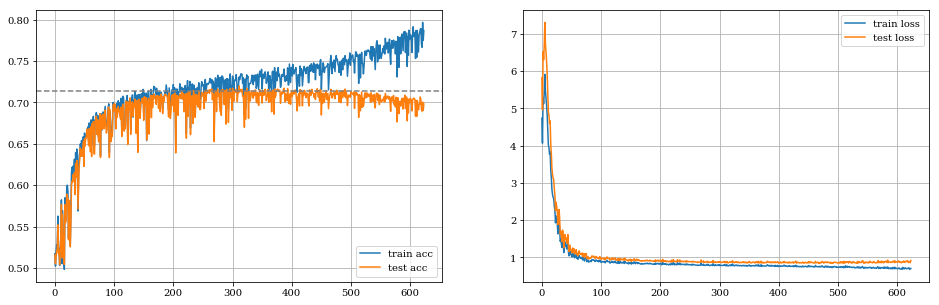

Batch 15615 (3997440 samples) complete

KeyboardInterrupt: 

In [33]:
# Train
# n_epochs = 60  # to specify custom n_epochs to run
n_total_batches = ((n_epochs + 1) * n_train) // batch_size
# n_total_batches = 500  # to specify custom n_batches to run
train_iteration()

In [ ]:
# Final training directive (sample test accuracy every batch)
n_epochs = 15
log_period_batches = 100
n_total_batches = ((n_epochs + 1) * n_train) // batch_size
train_iteration()
n_epochs = 70
log_period_batches = 1
n_total_batches = ((n_epochs + 1) * n_train) // batch_size
train_iteration()

In [223]:
n_epochs = 30
log_period_batches = 500
n_total_batches = ((n_epochs + 1) * n_train) // batch_size
n_total_batches

8500

In [32]:
def train_iteration(es=np.inf):
    global batch_i, n_total_batches, train_loss, test_loss, train_accuracy, test_accuracy, best_acc, best_acc_tr, best_acc_he, \
        best_preds, log_period_batches, batch_size
    
    b_no_inp = 0
    while batch_i < n_total_batches and b_no_inp < es:  # Stop when we reach max. batches or early stopping criterion
    # while epochs_completed < n_epochs:

        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_xchs, batch_xppos, \
            batch_xspell1, batch_xspell2, batch_pastelo, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
#         s, _ = sess.run([merged_summary, train_step], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
        sess.run([train_step], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
            **{x: batch_xs, x_chmp: batch_xchs, x_ppos: batch_xppos, x_spell1: batch_xspell1, x_spell2: batch_xspell2, \
               x_pastelo: batch_pastelo, keep_prob: dropout_keep_prob, rnn_kp: dropout_rnn}})
#         writer.add_summary(s, batch_i)
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                   {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                 **{x: X_train[indices], x_chmp: X_champions_train[indices], x_ppos: X_pick_positions_train[indices], \
                    x_spell1: X_spell1s_train[indices], x_spell2: X_spell2s_train[indices], \
                    x_pastelo: X_pastelos_train[indices], keep_prob: 1.0, rnn_kp: 1.0}})

            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
                  {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
                   x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
                   x_pastelo: X_pastelos_test, keep_prob: 1.0, rnn_kp: 1.0}})

            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc and test_a < train_a:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  "Best test acc res:", best_acc_tr, max(test_accuracy), best_acc_he, np.argmax(test_accuracy))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
            g.axhline(y=0.714, ls='--', color='grey')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                    "model_logs/" + model_name + '_log_latest', pad=False)
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
            plt.show()
    return best_acc

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss), (best test acc accs)

In [249]:
sess.close()

In [314]:
sess = tf.Session()

In [315]:
# with tf.Session() as sess:
saver.restore(sess, "./models/" + 'rnn_mt_model/rnn_mt_model')
# saver.restore(sess, "./models/" + model_name + '/' + model_name)

n_train_test_batch = 256
train_ls, train_as, train_hes = [], [], []
for j in range(n_train_test // n_train_test_batch):
    o = j * n_train_test_batch
    xrs_feed = {xr[i]: Xr_train[i][o:o + n_train_test_batch] for i in N_PL_r}
    xrsls_feed = {xrsl[i]: Xr_sl_train[i][o:o + n_train_test_batch] for i in N_PL_r}
    ycs_feed = {yc[i]: Yc_train[i][o:o + n_train_test_batch] for i in range(len(Yc_targets))}
    yrs_feed = {yr[i]: Yr_train[i][o:o + n_train_test_batch] for i in range(len(Yr_targets))}
    train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
           {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
         **{x: X_train[o:o + n_train_test_batch], x_chmp: X_champions_train[o:o + n_train_test_batch], \
            x_ppos: X_pick_positions_train[o:o + n_train_test_batch], \
            x_spell1: X_spell1s_train[o:o + n_train_test_batch], x_spell2: X_spell2s_train[o:o + n_train_test_batch], \
            x_pastelo: X_pastelos_train[o:o + n_train_test_batch], keep_prob: 1.0, rnn_kp: 1.0}})
    train_ls.append(train_l)
    train_as.append(train_a)
    train_hes.append(train_he)

xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
      {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
    **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
       x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
       x_pastelo: X_pastelos_test, keep_prob: 1.0, rnn_kp: 1.0}})

train_a, train_l, train_he = np.mean(train_as), np.mean(train_ls), np.mean(train_hes)

print("Results:", train_a, test_a, test_he, "Losses:", train_l, test_l)

INFO:tensorflow:Restoring parameters from ./models/rnn_mt_model/rnn_mt_model
Results: 0.73307294 0.7142535 0.6798501 Losses: 0.5346962 0.85933346


In [17]:
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    x_pastelos = X_pastelos_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, x_pastelos, ycs, yrs

In [140]:
def evalAutoLog(a, b, g, ra, rb, rg):
    global n_features, \
        batch_i, n_total_batches, train_loss, test_loss, train_accuracy, test_accuracy, best_acc, best_acc_tr, best_acc_he, \
        best_preds, log_period_batches, epochs_completed, current_i, epoch_shuf, sess, batch_size, dd, \
        x, xr, xrsl, x_chmp, x_ppos, x_spell1, x_spell2, x_pastelo, yc, yr, keep_prob, rnn_kp, \
        model_name, saver, train_step, loss, accuracy, accuracy_high_elo, dropout_keep_prob, dropout_rnn, n_train_test

    if (a, b, g, ra, rb, rg) in dd:
        return dd[(a, b, g, ra, rb, rg)]
    
    model_name = "rnn_mt_model"
    blue_win_i = Yc_use.index("blue_win")
    train_set_test_frac = 0.2  # Get training accuracy for random 20% subset of train set
    log_period_batches = 500
    n_epochs = 50
    learning_rate_amsgrad = 3.5 * 1e-5
    # learning_rate_adam = 3.5 * 1e-5
    # learning_rate_sgd = 0.01
    regr_loss_ratio = 1.0 * 1e-2
    dropout_keep_prob = 0.67
    dropout_rnn = 0.55
    batch_size = 256
    lstm_forget_bias = 1.0
    c_type = "GRU" # "Vanilla", "LSTM"

    pre_rnn1_units = 256
    # pre_rnn2_units = 256
    # pre_rnn3_units = 256
    # pre_rnn_shared_units = 256
    n_rnn_units = 256
    n_rnn_stacked = 1
    post_rnn_units = 256
    pre_join_x_units = 4096
    l1_n_units = 4096
    l2_n_units = 4096
    l3_n_units = 4096
    l4_n_units = 4096
    # l5_n_units = 4096
    # l6_n_units = 4096
    # final_layer_units = 4096

    # Define next batch function
    current_i, epochs_completed = 0, 0
    epoch_shuf = np.arange(n_train)
    np.random.shuffle(epoch_shuf)

    n_train_test = int(train_set_test_frac * n_train)
    izer = tf.contrib.layers.xavier_initializer()
    tf.reset_default_graph()
    train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

    def beta_swish(x):
        beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
        return x * tf.nn.sigmoid(beta * x)
    def swish(x):
        return x * tf.nn.sigmoid(x)
    def autolog(x, x_min, n_feats, alpha=None, beta=None, gamma=None):
        with tf.name_scope("autolog"):
    #         x_ = tf.clip_by_value(x, -4.5, 4.5)
            if alpha is None: alpha = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
            if beta is None:  beta  = tf.Variable(np.tile(0.4, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
            if gamma is None: gamma = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
    #         alpha = tf.constant(0.1, name='autolog-alpha')
    #         beta = tf.constant(0.4, name='autolog-beta')
    #         gamma = tf.constant(0.1, name='autolog-gamma')
            act = (alpha * x) + \
                tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
#             tf.summary.histogram("autolog_alpha", alpha)
#             tf.summary.histogram("autolog_beta", beta)
#             tf.summary.histogram("autolog_gamma", gamma)
#             tf.summary.histogram("autolog_activation", act)
            return act

    x = tf.placeholder(tf.float32, [None, n_features], name='x')
    xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_" + r + "_rnn") for r in t_roles]
    xrsl = [tf.placeholder(tf.int32, [None], name="seq_len_" + r) for r in t_roles]
    x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
    x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
    x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
    x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
    x_pastelo = tf.placeholder(tf.float32, [None, N_PL], name="x_pastelos")
    yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_labels") for i in range(len(Yc_targets))]
    yr = [tf.placeholder(tf.float32, [None, 1], name=(Yr_use[i] if f2(Yr_use[i]) not in t_roles else \
            '_'.join(Yr_use[i].split('_')[2:] + [f2(Yr_use[i])])) + "_targets") for i in range(len(Yr_targets))]
    keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
    rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

    n_champions = len(champ_dict)
    # n_input_feats = n_features
    # n_input_feats = n_features + (N_PL ** 2)
    n_features = X_train.shape[1]
    n_input_feats = n_features + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

    def bnorm_appl(inp):
        return dropout(bnorm(inp), keep_prob)
    #     return inp

    xr_alphas = [tf.Variable(np.tile(ra, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    xr_betas = [tf.Variable(np.tile(rb, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    xr_gammas = [tf.Variable(np.tile(rg, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    # xr_alphas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    # xr_betas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.4, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    # xr_gammas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    # x_alpha = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)
    # x_beta = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.4, n_features).astype(np.float32), trainable=True)
    # x_gamma = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)

    with tf.name_scope("metadata"):
    #     b_size = tf.shape(x)[0]
        x_reg = tf.gather(x, X_reg_idx, axis=1)

    with tf.name_scope("past_games"):
    #     xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
        xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), \
                      Xr_mins[i % 5], n_rec_features, xr_alphas[i % 5], xr_betas[i % 5], xr_gammas[i % 5]) for i in N_PL_r]
    with tf.name_scope("recurrent"):
        # Construct pre-rnn layers
        with tf.name_scope("pre_rnn_fc"):
            Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
            Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
            # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
            # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
            # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
            # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
            # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
            # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

            pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
            # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
            # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
            # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
            pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

        with tf.name_scope("rnn"):
            def get_rnn_cell(c_type, lstm_forget_bias, kp):
              cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                    (rnn.BasicRNNCell(n_rnn_units, name="rnn_cell") if c_type == "Vanilla" else \
                     rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell"))
              return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
            if n_rnn_stacked > 1:
            #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
                cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
            else:
            #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
                cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)

            with tf.name_scope("rnn_beginToken_W"):
    #             W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
                W_begin_token = [tf.Variable(izer([len(X_reg_idx) + 1, n_rnn_units]), name=r) for r in roles_all]
            with tf.name_scope("rnn_beginToken_b"):
                b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

            # Define rnn cell initial state
            x_token = [tf.concat([x_reg, tf.gather(x_pastelo, [i], axis=1)], axis=1) for i in N_PL_r]
            init_states = [tf.matmul(x_token[i], W_begin_token[i % 5]) + b_begin_token[i % 5] for i in N_PL_r]
    #         init_states = [tf.tile(W_begin_token[i], [tf.shape(xrsl[0])[0], 1]) for i in range(5)]
            rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i],
                                        dtype=tf.float32) for i in N_PL_r])
            # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
            #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
            #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
            rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

        with tf.name_scope("post_rnn_fc"):
            Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
            Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
            Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
            # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

            post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
            rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

    #     with tf.name_scope("post_rnn_fc"):
    #         Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
    #         Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
    #         post_rnn_lin = [leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5]) for i in N_PL_r]

    # with tf.name_scope("flat_mods"):
    #     Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
    #     # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

    #     post_rnn_layers = [bnorm_appl(post_rnn_lin[i]) for i in N_PL_r]
    #     rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

    with tf.name_scope("flat_mods"):
        x_alpha = tf.Variable(np.tile(a, n_features).astype(np.float32), trainable=True)
        x_beta = tf.Variable(np.tile(b, n_features).astype(np.float32), trainable=True)
        x_gamma = tf.Variable(np.tile(g, n_features).astype(np.float32), trainable=True)

        with tf.name_scope("team_compositions"):
            # Add champion compositions and pick positions
            x_champsum = tf.one_hot(x_chmp, n_champions)
            x_pposes = tf.one_hot(x_ppos, N_PL)
            x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
            x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
            x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
    #         x_input = autolog(x, X_mins, n_features, x_alpha, x_beta, x_gamma)
            x_input = tf.concat([autolog(x, X_mins, n_features, x_alpha, x_beta, x_gamma),
                                 x_ch_bsum,
                                 x_ch_rsum,
                                 tf.reshape(x_pposes, [-1, N_PL ** 2]),
                                 tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)
    #                              tf.reshape(x_pposes, [-1, N_PL ** 2])], axis=1)

        with tf.name_scope("fully_connected"):
            Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
            bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

            W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
            # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
            b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
            W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
            b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
            W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
            b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
            W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
            b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
            # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
            # b_5 = tf.Variable(izer([l5_n_units]))
            # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
            # b_6 = tf.Variable(izer([l6_n_units]))
            # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
            # b_7 = tf.Variable(izer([n_outputs]))

            pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

        #     relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1)
            relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
            # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

            relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
            relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
            relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
            # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
            # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
            # drop_out = dropout(relu_2, keep_prob)
            # y_out = tf.matmul(drop_out, W_3) + b_3
            # y_out = tf.matmul(relu_3, W_4) + b_4
            #   y_prob = tf.nn.softmax(y_out)

        with tf.name_scope("final_output"):
            # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
            # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
            # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
            # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
            # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
            # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
            # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
            # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

            with tf.name_scope("output_W"):
                Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
                Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            with tf.name_scope("output_b"):
                Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
                Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

            # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
            # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
            # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
            # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

            with tf.name_scope("classif_outs"):
                Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
            with tf.name_scope("regr_outs"):
                Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

        # Define loss function & training step
        with tf.name_scope("loss"):
            with tf.name_scope("classif_xent_loss"):
                Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                             labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
            with tf.name_scope("regr_l2_losses"):
                Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
        #         loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
            loss = sum(Yc_losses)
            if regr_loss_ratio > 0: loss += (regr_loss_ratio * tf.reduce_mean(Yr_losses))

        with tf.name_scope("train"):
    #         flat_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "flat_mods")
    #         train_step = AMSGrad(learning_rate=learning_rate_amsgrad,
    #                                 beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss, var_list=flat_trainables)
            train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
            # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
        #     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

        with tf.name_scope("accuracy"):
            # Define accuracy computation
            correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
            accuracy = tf.reduce_mean(correct)
            accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

#     tf.summary.scalar("loss", loss)
#     tf.summary.scalar("accuracy", accuracy)
#     merged_summary = tf.summary.merge_all()

    # Train
    batch_i = 0
    best_acc = 0
    best_acc_tr = 0
    best_acc_he = 0
    best_preds = None
    saver = tf.train.Saver()
    create_folder("models")
    create_folder("models/" + model_name)
    create_folder("model_formats")
    create_folder(learning_data_dir)
    create_folder(learning_data_dir + "models")
    # save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False)
    
    n_total_batches = n_epochs * n_train / batch_size
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # Train
    n_epochs = 10  # initial epochs before we start measuring accuracy
    n_total_batches = ((n_epochs + 1) * n_train) // batch_size
    # n_total_batches = 500  # to specify custom n_batches to run
    log_period_batches = 250
    train_iteration()
    early_stopping = 2000  # Number of batches without improvement before we stop
    n_epochs = 70  # max epochs (if early stopping doesn't work... not sure how it wouldn't)
#     print("N epochs:", n_epochs)
    n_total_batches = ((n_epochs + 1) * n_train) // batch_size
    log_period_batches = 25
    return train_iteration(es=early_stopping)

In [141]:
optimizer = BayesianOptimization(f=evalAutoLog, pbounds={"a": (0.02, 0.12),  "b": (0.35, 0.7),  "g": (0.02, 0.12), \
                                                        "ra": (0.02, 0.12), "rb": (0.15, 0.6), "rg": (0.02, 0.12)})

In [106]:
# optimizer.probe(params={"ra": 1.9124, "c_2": 1000.0}, lazy=False)

In [142]:
pkeys = ['a', 'b', 'g', 'ra', 'rb', 'rg']

In [143]:
# data_list = [
#  [.7038008,.1182673336342546,.3884885281683841,.11336763481163784,.09106884382944176,.4340142194596994,.09639509844097661],
#  [.70494044,.11123295907434519,.36610961881143195,.1182453356964665,.11158683678204304,.4360919660892794,.10337962426751532],
#  [.7072197794914246,.08779385040161565,.39387365795918566,.08942633113878981,.10923600595870916,.4082896195088477,.08129563384408162],
# ]
# data_list = [([r["target"]] + [r["params"][k] for k in pkeys]) for r in optimizer.res]
dd = {(a, b, g, ra, rb, rg): z for (z, a, b, g, ra, rb, rg) in data_list}
len(data_list)

13

In [145]:
for d_ in data_list:
    optimizer.probe(params=dict(zip(pkeys, tuple(d_[1:]))), lazy=True)

In [ ]:
|  9        |  0.7086   |  0.08     |  0.45     |  0.08     |  0.08     |  0.35     |  0.08     |

Epoch 17 : 0.7122809 0.6922332 0.65394735 loss: 0.8696929 0.97485375 Best test acc res: 0.71149737 0.70431364 0.65 60


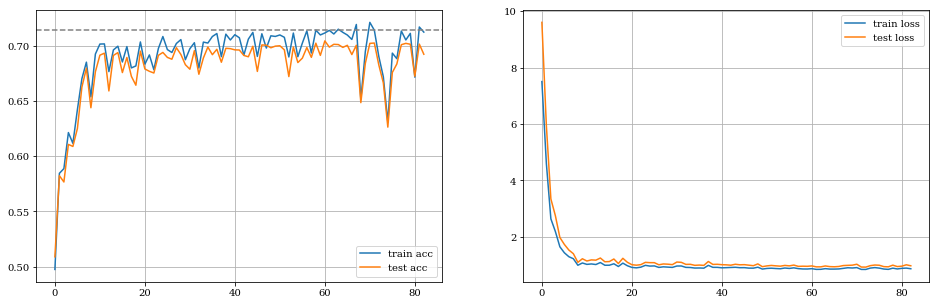

Batch 4800 (1228800 samples) complete

In [ ]:
optimizer.maximize(init_points=0, n_iter=50)

In [113]:
optimizer.set_bounds(new_bounds={"a": (0.02, 0.12), "b": (0.35, 0.7), "g": (0.02, 0.12), \
                                 "ra": (0.02, 0.12), "rb": (0.15, 0.6), "rg": (0.02, 0.12)})

In [149]:
optimizer.max

{'target': 0.7143996953964233,
 'params': {'a': 0.02,
  'b': 0.35,
  'g': 0.020000026617608142,
  'ra': 0.02,
  'rb': 0.15,
  'rg': 0.11999999999999997}}

In [147]:
optimizer.res

[{'target': 0.7038008,
  'params': {'a': 0.1182673336342546,
   'b': 0.3884885281683841,
   'g': 0.11336763481163784,
   'ra': 0.09106884382944176,
   'rb': 0.4340142194596994,
   'rg': 0.09639509844097661}},
 {'target': 0.70494044,
  'params': {'a': 0.11123295907434519,
   'b': 0.36610961881143195,
   'g': 0.1182453356964665,
   'ra': 0.11158683678204304,
   'rb': 0.4360919660892794,
   'rg': 0.10337962426751532}},
 {'target': 0.7072197794914246,
  'params': {'a': 0.08779385040161565,
   'b': 0.39387365795918566,
   'g': 0.08942633113878981,
   'ra': 0.10923600595870916,
   'rb': 0.4082896195088477,
   'rg': 0.08129563384408162}},
 {'target': 0.7062510848045349,
  'params': {'a': 0.08,
   'b': 0.44999999999999984,
   'g': 0.11999999999999995,
   'ra': 0.11999999999999993,
   'rb': 0.3500000025126707,
   'rg': 0.11999999685383247}},
 {'target': 0.7085304260253906,
  'params': {'a': 0.0800000193924919,
   'b': 0.3500000662838117,
   'g': 0.08,
   'ra': 0.08000000000173227,
   'rb': 0.35

In [ ]:
[{'target': 0.7038008,
  'params': {'a': 0.1182673336342546,
   'b': 0.3884885281683841,
   'g': 0.11336763481163784,
   'ra': 0.09106884382944176,
   'rb': 0.4340142194596994,
   'rg': 0.09639509844097661}},
 {'target': 0.70494044,
  'params': {'a': 0.11123295907434519,
   'b': 0.36610961881143195,
   'g': 0.1182453356964665,
   'ra': 0.11158683678204304,
   'rb': 0.4360919660892794,
   'rg': 0.10337962426751532}},
 {'target': 0.7072197794914246,
  'params': {'a': 0.08779385040161565,
   'b': 0.39387365795918566,
   'g': 0.08942633113878981,
   'ra': 0.10923600595870916,
   'rb': 0.4082896195088477,
   'rg': 0.08129563384408162}},
 {'target': 0.7062510848045349,
  'params': {'a': 0.08,
   'b': 0.44999999999999984,
   'g': 0.11999999999999995,
   'ra': 0.11999999999999993,
   'rb': 0.3500000025126707,
   'rg': 0.11999999685383247}},
 {'target': 0.7085304260253906,
  'params': {'a': 0.0800000193924919,
   'b': 0.3500000662838117,
   'g': 0.08,
   'ra': 0.08000000000173227,
   'rb': 0.35,
   'rg': 0.08}},
 {'target': 0.7050544023513794,
  'params': {'a': 0.11999990313103309,
   'b': 0.35,
   'g': 0.08,
   'ra': 0.1199999999999962,
   'rb': 0.3500001489170006,
   'rg': 0.08000000000000183}},
 {'target': 0.7080745100975037,
  'params': {'a': 0.08000023210090543,
   'b': 0.4499999999892385,
   'g': 0.0800000000052621,
   'ra': 0.08000014083241372,
   'rb': 0.3500003520780385,
   'rg': 0.08000000000005268}},
 {'target': 0.7061941027641296,
  'params': {'a': 0.08000000497077653,
   'b': 0.35,
   'g': 0.11999999746946166,
   'ra': 0.08,
   'rb': 0.35,
   'rg': 0.11999999914014278}},
 {'target': 0.7085874080657959,
  'params': {'a': 0.08,
   'b': 0.4499999999999995,
   'g': 0.08,
   'ra': 0.08,
   'rb': 0.35,
   'rg': 0.08}}]

In [ ]:
data_list = [[0.7038008,
  0.1182673336342546,
  0.3884885281683841,
  0.11336763481163784,
  0.09106884382944176,
  0.4340142194596994,
  0.09639509844097661],
 [0.70494044,
  0.11123295907434519,
  0.36610961881143195,
  0.1182453356964665,
  0.11158683678204304,
  0.4360919660892794,
  0.10337962426751532],
 [0.7072197794914246,
  0.08779385040161565,
  0.39387365795918566,
  0.08942633113878981,
  0.10923600595870916,
  0.4082896195088477,
  0.08129563384408162],
 [0.7062510848045349,
  0.08,
  0.44999999999999984,
  0.11999999999999995,
  0.11999999999999993,
  0.3500000025126707,
  0.11999999685383247],
 [0.7085304260253906,
  0.0800000193924919,
  0.3500000662838117,
  0.08,
  0.08000000000173227,
  0.35,
  0.08],
 [0.7050544023513794,
  0.11999990313103309,
  0.35,
  0.08,
  0.1199999999999962,
  0.3500001489170006,
  0.08000000000000183],
 [0.7080745100975037,
  0.08000023210090543,
  0.4499999999892385,
  0.0800000000052621,
  0.08000014083241372,
  0.3500003520780385,
  0.08000000000005268],
 [0.7061941027641296,
  0.08000000497077653,
  0.35,
  0.11999999746946166,
  0.08,
  0.35,
  0.11999999914014278],
 [0.7085874080657959, 0.08, 0.4499999999999995, 0.08, 0.08, 0.35, 0.08],
 [0.7123482823371887,
  0.05000046057254798,
  0.5499992195200041,
  0.05000016590658845,
  0.05,
  0.2500003600536527,
  0.05000007135361041],
 [0.7126331925392151,
  0.05,
  0.55,
  0.05000004589022806,
  0.05000000619145823,
  0.45,
  0.11999995937677868],
 [0.7124622464179993,
  0.051093039563232245,
  0.5434471552263664,
  0.05161830731458505,
  0.0998057206976953,
  0.2544925176267504,
  0.11015851772093557],
 [0.7113795876502991,
  0.09174679835736643,
  0.5479278433684973,
  0.050748121154870623,
  0.056423050796163984,
  0.25449536828795033,
  0.11945163295426864]]

Transfer learning for individual players

In [286]:
# First, define the full feature architecture and restore weights from disk

In [340]:
sess.close()

In [341]:
model_name = "rnn_mt_model"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 500000
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_sgd = 0.01
regr_loss_ratio = 1.0 * 1e-2
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 4096
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
def next_batch(sz):
    global epoch_shuf, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    xs = X_train[batch_idx]
    xrs = [Xr_[batch_idx] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[batch_idx] for Xr_sl_ in Xr_sl_train]
    x_chmps = X_champions_train[batch_idx]
    x_pposs = X_pick_positions_train[batch_idx]
    x_spell1s = X_spell1s_train[batch_idx]
    x_spell2s = X_spell2s_train[batch_idx]
    x_pastelos = X_pastelos_train[batch_idx]
    ycs = [Yc_[batch_idx] for Yc_ in Yc_train]
    yrs = [Yr_[batch_idx] for Yr_ in Yr_train]
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        np.random.shuffle(epoch_shuf)
        epochs_completed += 1
    return xs, xrs, xrsls, x_chmps, x_pposs, x_spell1s, x_spell2s, x_pastelos, ycs, yrs

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats, alpha=None, beta=None, gamma=None):
    with tf.name_scope("autolog"):
        if alpha is None: alpha = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        if beta is None:  beta  = tf.Variable(np.tile(0.4, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        if gamma is None: gamma = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
#         alpha = tf.constant(0.1, name='autolog-alpha')
#         beta = tf.constant(0.4, name='autolog-beta')
#         gamma = tf.constant(0.1, name='autolog-gamma')
        act = (alpha * x) + \
            tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x = tf.placeholder(tf.float32, [None, n_features], name='x')
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_" + r + "_rnn") for r in t_roles]
xrsl = [tf.placeholder(tf.int32, [None], name="seq_len_" + r) for r in t_roles]
x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
x_pastelo = tf.placeholder(tf.float32, [None, N_PL], name="x_pastelos")
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_labels") for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1], name=(Yr_use[i] if f2(Yr_use[i]) not in t_roles else \
        '_'.join(Yr_use[i].split('_')[2:] + [f2(Yr_use[i])])) + "_targets") for i in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

n_champions = len(champ_dict)
n_input_feats = n_features + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

def bnorm_appl(inp):
    return dropout(bnorm(inp), keep_prob)

with tf.name_scope("metadata"):
#     b_size = tf.shape(x)[0]
    x_reg = tf.gather(x, X_reg_idx, axis=1)

with tf.name_scope("past_games"):
#     xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
    xr_alphas = [tf.Variable(np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    xr_betas = [tf.Variable(np.tile(0.4, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    xr_gammas = [tf.Variable(np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
    xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), \
                  Xr_mins[i % 5], n_rec_features, xr_alphas[i % 5], xr_betas[i % 5], xr_gammas[i % 5]) for i in N_PL_r]
with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
    with tf.name_scope("pre_rnn_fc"):
        Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
        Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
        # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
        # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
        # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
        # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
        # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
        # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

        pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
        # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
        # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
        pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

    with tf.name_scope("rnn"):
        def get_rnn_cell(c_type, lstm_forget_bias, kp):
          cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                 rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
          return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
        if n_rnn_stacked > 1:
        #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
            cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
        else:
        #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
            cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)

        with tf.name_scope("rnn_beginToken_W"):
#             W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
            W_begin_token = [tf.Variable(izer([len(X_reg_idx) + 1, n_rnn_units]), name=r) for r in roles_all]
        with tf.name_scope("rnn_beginToken_b"):
            b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

        # Define rnn cell initial state
        x_token = [tf.concat([x_reg, tf.gather(x_pastelo, [i], axis=1)], axis=1) for i in N_PL_r]
        init_states = [tf.matmul(x_token[i], W_begin_token[i % 5]) + b_begin_token[i % 5] for i in N_PL_r]
#         init_states = [tf.tile(W_begin_token[i], [tf.shape(xrsl[0])[0], 1]) for i in range(5)]
        rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i % 5],
                                    dtype=tf.float32) for i in N_PL_r])
        # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
        #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
        #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
        rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

    with tf.name_scope("post_rnn_fc"):
        Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
        # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

        post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
        rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

with tf.name_scope("team_compositions"):
    # Add champion compositions and pick positions
    x_champsum = tf.one_hot(x_chmp, n_champions)
    x_pposes = tf.one_hot(x_ppos, N_PL)
    x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
    x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
    x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
    x_input = tf.concat([autolog(x, X_mins, n_features),
                         x_ch_bsum,
                         x_ch_rsum,
                         tf.reshape(x_pposes, [-1, N_PL ** 2]),
                         tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)

with tf.name_scope("fully_connected"):
    Wp_1 = tf.Variable(izer([n_input_feats, pre_join_x_units]), name='W_xin_linear')
    bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

    W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
    # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
    b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
    W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
    b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
    W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
    b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
    W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
    b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
    # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
    # b_5 = tf.Variable(izer([l5_n_units]))
    # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
    # b_6 = tf.Variable(izer([l6_n_units]))
    # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
    # b_7 = tf.Variable(izer([n_outputs]))

    pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

#     relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1)
    relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
    # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

    relu_2 = bnorm_appl(tf.matmul(relu_1, W_2) + b_2)
    relu_3 = bnorm_appl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
    relu_4 = bnorm_appl(tf.matmul(relu_3, W_4) + b_4)
    # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
    # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
    # drop_out = dropout(relu_2, keep_prob)
    # y_out = tf.matmul(drop_out, W_3) + b_3
    # y_out = tf.matmul(relu_3, W_4) + b_4
    #   y_prob = tf.nn.softmax(y_out)

with tf.name_scope("final_output"):
    # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
    # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
    # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
    # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
    # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
    # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
    # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
    # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

    with tf.name_scope("output_W"):
        Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
        Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
    with tf.name_scope("output_b"):
        Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

    # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
    # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
    # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
    # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

    with tf.name_scope("classif_outs"):
        Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
    with tf.name_scope("regr_outs"):
        Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

# Define loss function & training step
with tf.name_scope("loss"):
    with tf.name_scope("classif_xent_loss"):
        Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                     labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
    with tf.name_scope("regr_l2_losses"):
        Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
#         loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
    loss = sum(Yc_losses) + (regr_loss_ratio * tf.reduce_mean(Yr_losses))

with tf.name_scope("train"):
    train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
    # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
#     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

with tf.name_scope("accuracy"):
    # Define accuracy computation
    correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
    accuracy = tf.reduce_mean(correct)
    accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
merged_summary = tf.summary.merge_all()

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
# save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False) # comment this out if restoring train/test indices

In [342]:
sess = tf.Session()

In [343]:
model_name_full = "rnn_mt_model"
saver.restore(sess, "./models/" + model_name_full + '/' + model_name_full) # Restore full match model & test

n_train_test_batch = 256
train_ls, train_as, train_hes = [], [], []
for j in range(n_train_test // n_train_test_batch):
    o = j * n_train_test_batch
    xrs_feed = {xr[i]: Xr_train[i][o:o + n_train_test_batch] for i in N_PL_r}
    xrsls_feed = {xrsl[i]: Xr_sl_train[i][o:o + n_train_test_batch] for i in N_PL_r}
    ycs_feed = {yc[i]: Yc_train[i][o:o + n_train_test_batch] for i in range(len(Yc_targets))}
    yrs_feed = {yr[i]: Yr_train[i][o:o + n_train_test_batch] for i in range(len(Yr_targets))}
    train_l, train_a, train_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
           {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
         **{x: X_train[o:o + n_train_test_batch], x_chmp: X_champions_train[o:o + n_train_test_batch], \
            x_ppos: X_pick_positions_train[o:o + n_train_test_batch], \
            x_spell1: X_spell1s_train[o:o + n_train_test_batch], x_spell2: X_spell2s_train[o:o + n_train_test_batch], \
            x_pastelo: X_pastelos_train[o:o + n_train_test_batch], keep_prob: 1.0, rnn_kp: 1.0}})
    train_ls.append(train_l)
    train_as.append(train_a)
    train_hes.append(train_he)

xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
test_l, test_a, test_he = sess.run([loss, accuracy, accuracy_high_elo], feed_dict= \
      {**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
    **{x: X_test, x_chmp: X_champions_test, x_ppos: X_pick_positions_test, \
       x_spell1: X_spell1s_test, x_spell2: X_spell2s_test, \
       x_pastelo: X_pastelos_test, keep_prob: 1.0, rnn_kp: 1.0}})

train_a, train_l, train_he = np.mean(train_as), np.mean(train_ls), np.mean(train_hes)

print("Results:", train_a, test_a, test_he, "Losses:", train_l, test_l)

INFO:tensorflow:Restoring parameters from ./models/rnn_mt_model/rnn_mt_model
Results: 0.7324219 0.71385896 0.6790175 Losses: 0.539725 0.82563686


In [344]:
# Get indices of history feature group for each role
history_suffixes = ['_'.join(l.split('_')[2:]) for l in X_labels if f2(l) == "blue_top" and \
    ("_champion_all_" in l or "_champion_avg_" in l or "_champion_seasonavg_" in l)]
shared_X = [l for l in X_labels if l.split('_')[0] not in cols_all and l != "elo"]
shared_X_idx = [X_labels.index(l) for l in shared_X]
history_feat_idx = np.asarray([[X_labels.index(t_roles[j] + '_' + l) for l in history_suffixes] + shared_X_idx for j in N_PL_r])

# Get indices of regression targets for each role (some are shared)
shared_Yr = [l for l in Yr_use if f2(l) not in t_roles and l.split('_')[0] not in cols_all]
Yr_idx = np.asarray([[Yr_use.index(l) for l in shared_Yr + [l_ for l_ in Yr_use if f2(l_) == r]] for r in t_roles])
Yr_targs = shared_Yr + ['_'.join(l.split('_')[2:]) for l in Yr_use if f2(l) == "blue_top"]
Yc_targs = ["win"]
n_features_history = len(history_feat_idx[0])
n_Yr = len(Yr_idx[0])
X_mins_mi = np.min([X_mins[idx] for idx in history_feat_idx], axis=0).astype(np.float32)
high_elo_test_is_mi = np.hstack([high_elo_test_is + (n_test * i) for i in range(10)])

In [345]:
X_inf_labels = history_suffixes + shared_X
len(X_inf_labels)

54

In [346]:
# sess = tf.Session()

# print(sess.run(   tf.squeeze(tf.where(tf.equal(tf.constant([1,2,3,4,3,4,3]), 3)))  ))

# sess.close()

In [347]:
model_name = "momentum_rnn"
blue_win_i_mi = Yc_targs.index("win")
train_set_test_frac = 0.05  # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 15
learning_rate_amsgrad = 1.0 * 1e-3
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_sgd = 0.01
# regr_loss_ratio_mi = 1.0 * 1e-2
dropout_keep_prob_mi = 0.67
dropout_rnn_mi = 0.55
batch_size_mi = 256
lstm_forget_bias_mi = 1.0
c_type_mi = "GRU"

# pre_rnn1_units = 256
# # pre_rnn2_units = 256
# # pre_rnn3_units = 256
# # pre_rnn_shared_units = 256
# n_rnn_units = 256
# n_rnn_stacked = 1
# post_rnn_units = 256
pre_join_x_units_mi = 512
l1_n_units_mi = 512
l2_n_units_mi = 512
# l3_n_units = 512
# l4_n_units = 512
# l5_n_units = 512
# l6_n_units = 512
# final_layer_units = 512

# Define next batch function
miniepoch_i, current_i, epochs_completed = 0, 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
pl_ordering = np.asarray([np.random.choice(10, 10, replace=False) for _ in range(n_train)])
def _get_individuals(X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx, pl_idx):
    x_mb = X___d[batch_idx, np.asarray([history_feat_idx[pl_idx[i]] for i in range(len(batch_idx))]).T].T
#     x_mb = np.asarray([X___d[batch_idx[i], history_feat_idx[pl_idx[i]]].T for i in range(len(batch_idx))])
    x_role_mb = (pl_idx % 5).astype(np.int32)
    xr_mb = np.asarray([Xr___d[pl_idx[i]][batch_idx[i]] for i in range(len(batch_idx))])
    xrsl_mb = np.asarray([Xr_sl___d[pl_idx[i]][batch_idx[i]] for i in range(len(batch_idx))])
    x_pastelo_mb = X_pastelos___d[batch_idx, pl_idx]    
    ycs = [Yc_[batch_idx] for Yc_ in Yc___d]
    yrs = np.asarray([[Yr___d[j][batch_idx[i]] for j in Yr_idx[pl_idx[i]]] for i in range(len(batch_idx))])
    yrs = [yrs[:, i] for i in range(yrs.shape[1])]
    # If red side, invert win
    red_is = np.nonzero(pl_idx >= 5)[0]
    if len(red_is) > 0:
        ycs[blue_win_i][red_is] = 1 - ycs[blue_win_i][red_is]
    return x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs
def get_individuals(X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx=None, pl_idx=None):
    if batch_idx is None:                              # Use full set
        batch_idx = np.arange(X___d.shape[0])
    if pl_idx is None:                                 # Use all players in each match
        pl_ord = np.tile(np.arange(N_PL), (min(X___d.shape[0], len(batch_idx)), 1))
        result = []
        for j in N_PL_r:
            result.append(list(_get_individuals(
              X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx, pl_ord[:, j])))
        return tuple([np.concatenate(res_) for res_ in list(zip(*result))[:-2]] + \
                     [[np.concatenate([res[-2][i] for res in result]) for i in range(len(result[0][-2]))]] + \
                     [[np.concatenate([res[-1][i] for res in result]) for i in range(len(result[0][-1]))]])
    return _get_individuals(X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx, pl_idx)
def next_batch(sz):
    global epoch_shuf, pl_ordering, miniepoch_i, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    pl_idx = pl_ordering[current_i:current_i + sz, miniepoch_i]
    res = get_individuals(X_train, Xr_train, Xr_sl_train, X_pastelos_train, Yc_train, Yr_train, batch_idx, pl_idx)
    
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        miniepoch_i += 1
        if miniepoch_i >= N_PL:
            miniepoch_i = 0
            epochs_completed += 1
            np.random.shuffle(epoch_shuf)
            pl_ordering = np.asarray([np.random.choice(10, 10, replace=False) for _ in range(n_train)])
    return res

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
# tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats, alpha=None, beta=None, gamma=None):
    with tf.name_scope("autolog"):
        if alpha is None: alpha = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        if beta is None:  beta  = tf.Variable(np.tile(0.4, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        if gamma is None: gamma = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
#         alpha = tf.constant(0.1, name='autolog-alpha')
#         beta = tf.constant(0.4, name='autolog-beta')
#         gamma = tf.constant(0.1, name='autolog-gamma')
        act = (alpha * x)
        act += tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x_mi = tf.placeholder(tf.float32, [None, n_features_history], name='x_history_mi')
x_role = tf.placeholder(tf.int32, [None], name='x_role_mi')
xr_mi = tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_rnn_mi")
xrsl_mi = tf.placeholder(tf.int32, [None], name="seq_len_mi")
x_pastelo_mi = tf.placeholder(tf.float32, [None], name="x_pastelo_mi")
yc_mi = [tf.placeholder(tf.float32, [None, 2], name="win")]
yr_mi = [tf.placeholder(tf.float32, [None, 1], name=l + '_mi') for l in Yr_targs]
keep_prob_mi = tf.placeholder(tf.float32, name="dropoutKeepProb_mi")
# rnn_kp_mi = tf.placeholder(tf.float32, name="rnnDropoutKeepProb_mi")

n_champions = len(champ_dict)
# n_input_feats_mi = n_features_history + 5
n_input_feats_mi = 5

with tf.name_scope("mi_model"):
    bnorm_counter_mi = -1
    def bnorm_appl_mi(inp):
        global bnorm_counter_mi
        bnorm_counter_mi += 1
        return dropout(bnorm(inp, name="mi_model_Bnorm_" + str(bnorm_counter_mi)), \
                       keep_prob_mi, name="mi_model_Dropout_" + str(bnorm_counter_mi))
    with tf.name_scope("metadata_mi"):
    #     b_size = tf.shape(x)[0]
        x_reg_mi = tf.gather(x_mi, X_reg_idx, axis=1)
    
        # First, group recurrent input by role
        role_idx = [tf.squeeze(tf.where(tf.equal(x_role, i))) for i in range(5)]
        stacked_roles = tf.concat(role_idx, axis=0)
        recovery_idx = tf.contrib.framework.argsort(stacked_roles, stable=True)
        xr_grp = [tf.gather(xr_mi, role_idx[i], axis=0) for i in range(5)]
        xrsl_grp = [tf.gather(xrsl_mi, role_idx[i], axis=0) for i in range(5)]
        x_reg_grp = [tf.gather(x_reg_mi, role_idx[i], axis=0) for i in range(5)]
        x_pastelo_grp = [tf.gather(tf.expand_dims(x_pastelo_mi, 1), role_idx[i], axis=0) for i in range(5)]

    with tf.name_scope("past_games_mi"):
    #     xr_sc_mi = (xr_mi - rec_median) / rec_iqr
        # Scale data
        xr_stacked_mi = [autolog(tf.reshape(xr_grp[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features,
                                  xr_alphas[i], xr_betas[i], xr_gammas[i]) for i in range(5)]

    with tf.name_scope("recurrent_mi"):
       # Construct pre-rnn layers
        with tf.name_scope("pre_rnn_fc_mi"):
            pre_l_1_mi = [tf.matmul(xr_stacked_mi[i], Xr_Wp1s[i]) + Xr_bp1s[i] for i in range(5)]
            pre_ls_mi = [tf.reshape(pre_l_1_mi[i], [-1, rec_max_len, pre_rnn1_units]) for i in range(5)]

        with tf.name_scope("rnn_mi"):
            x_token_mi = [tf.concat([x_reg_grp[i], x_pastelo_grp[i]], axis=1) for i in range(5)]
            init_states_mi = [tf.matmul(x_token_mi[i], W_begin_token[i]) + b_begin_token[i] for i in range(5)]
            rnn_os_mi, _ = zip(*[tf.nn.dynamic_rnn(cell, pre_ls_mi[i],
                                        sequence_length=xrsl_grp[i], initial_state=init_states_mi[i],
                                        dtype=tf.float32) for i in range(5)])
            rnn_outs_mi = [tf.gather_nd(rnn_os_mi[i],
                           tf.stack([tf.range(tf.shape(rnn_os_mi[i])[0]), xrsl_grp[i] - 1], axis=1)) for i in range(5)]

        with tf.name_scope("post_rnn_fc_mi"):
            Xr_W2s_mi = tf.Variable(izer([post_rnn_units, l1_n_units_mi]), name='W_rnn_post_2_linear')
            post_rnn_layers_mi = [bnorm_appl_mi(leaky_relu(tf.matmul(rnn_outs_mi[i], Xr_W1s[i]) + Xr_b1s[i])) for i in range(5)]
            post_rnn_layer_mi = tf.gather(tf.concat(post_rnn_layers_mi, axis=0), recovery_idx, axis=0)  # Reassemble batch
            rnn_output = bnorm_appl_mi(tf.matmul(post_rnn_layer_mi, Xr_W2s_mi))

#     with tf.name_scope("player_history_mi"):
#         x_input_hist = autolog(x_mi, X_mins_mi, n_features_history)

    with tf.name_scope("fully_connected_mi"):
#         x_input_mi = tf.concat([x_input_hist, tf.one_hot(x_role, 5)], axis=1)
        x_input_mi = tf.one_hot(x_role, 5)
    
        Wp_1_mi = tf.Variable(izer([n_input_feats_mi, pre_join_x_units_mi]), name='W_xin_linear')
        bp_1_mi = tf.Variable(izer([pre_join_x_units_mi]), name='b_xin_linear')

        W_1_mi = tf.Variable(izer([pre_join_x_units_mi, l1_n_units_mi]), name='W_fc_1_relu')
        b_1_mi = tf.Variable(izer([l1_n_units_mi]), name='b_fc_1_relu')
        W_2_mi = tf.Variable(izer([l1_n_units_mi, l2_n_units_mi]), name='W_fc_2_linear')
        b_2_mi = tf.Variable(izer([l2_n_units_mi]), name='b_fc_2_linear')
        pre_join_x_mi = tf.matmul(x_input_mi, Wp_1_mi) + bp_1_mi

        relu_1_mi = leaky_relu(tf.matmul(pre_join_x_mi, W_1_mi) + b_1_mi + rnn_output)
        relu_2_mi = bnorm_appl_mi(tf.matmul(relu_1_mi, W_2_mi) + b_2_mi)
    #     relu_3 = bnorm_appl_mi(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
    #     relu_4 = bnorm_appl_mi(tf.matmul(relu_3, W_4) + b_4)

    with tf.name_scope("final_output_mi"):
        with tf.name_scope("output_W_mi"):
            Yc_W2s_mi = [tf.Variable(izer([l2_n_units_mi, n_outputs[i]]), name=Yc_targs[i]) for i in range(len(Yc_targs))]
            Yr_W2s_mi = [tf.Variable(izer([l2_n_units_mi, 1]), name=Yr_use[i]) for i in range(len(Yr_targs))]
        with tf.name_scope("output_b_mi"):
            Yr_b2s_mi = [tf.Variable(izer([1]), name=Yr_targs[i]) for i in range(len(Yr_targs))]
            Yc_b2s_mi = [tf.Variable(izer([n_outputs[i]]), name=Yc_targs[i]) for i in range(len(Yc_targs))]

        with tf.name_scope("classif_outs_mi"):
            Yc_outs_mi = [leaky_relu(tf.matmul(relu_2_mi, Yc_W2s_mi[i]) + Yc_b2s_mi[i]) for i in range(len(Yc_targs))]
            Yc_outprobs_mi = [tf.nn.softmax(Yc_outs_mi[i]) for i in range(len(Yc_targs))]
        with tf.name_scope("regr_outs_mi"):
            Yr_outs_mi = [leaky_relu(tf.matmul(relu_2_mi, Yr_W2s_mi[i]) + Yr_b2s_mi[i]) for i in range(len(Yr_targs))]

    # Define loss function & training step
    with tf.name_scope("loss_mi"):
        with tf.name_scope("classif_xent_loss_mi"):
            Yc_losses_mi = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                         labels=yc_mi[i], logits=Yc_outs_mi[i])) for i in range(len(Yc_targs))]
        with tf.name_scope("regr_l2_losses_mi"):
            Yr_losses_mi = [tf.reduce_mean(tf.nn.l2_loss(yr_mi[i] - Yr_outs_mi[i])) for i in range(len(Yr_targs))]
    #         loss = sum(Yc_losses_mi + [tf.reduce_mean(Yr_losses_mi)])
        loss_mi = sum(Yc_losses_mi)# + (regr_loss_ratio_mi * tf.reduce_mean(Yr_losses_mi))

    with tf.name_scope("train_mi"):
        mi_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "mi_model")
        train_step_mi = AMSGrad(learning_rate=learning_rate_amsgrad,
                                beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss_mi, var_list=mi_trainables)
        # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
    #     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

    with tf.name_scope("accuracy_mi"):
        # Define accuracy computation
        correct_mi = tf.cast(tf.equal(tf.argmax(Yc_outs_mi[blue_win_i_mi], 1), tf.argmax(yc_mi[blue_win_i_mi], 1)), tf.float32)
        accuracy_mi = tf.reduce_mean(correct_mi)
        accuracy_high_elo_mi = tf.reduce_mean(tf.gather(correct_mi, high_elo_test_is_mi))

tf.summary.scalar("loss_mi", loss_mi)
tf.summary.scalar("accuracy_mi", accuracy_mi)
merged_summary = tf.summary.merge_all()

# Train
batch_i = 0
best_i = 0
best_acc = 0
best_acc_tr = 0
best_acc_he = 0
best_preds = None
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False) # comment this out if restoring train/test indices

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [348]:
sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "mi_model")))
create_folder("logs/tensorboard/" + model_name, overwrite=True)  # Train individual momentum-influence model
writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
writer.add_graph(sess.graph)

Epoch 15 : 0.50317144 0.5035282 0.4995837 loss: 0.69306844 0.6930876 Best test acc res: 0.50982857 0.5090627 0.5048293 1558


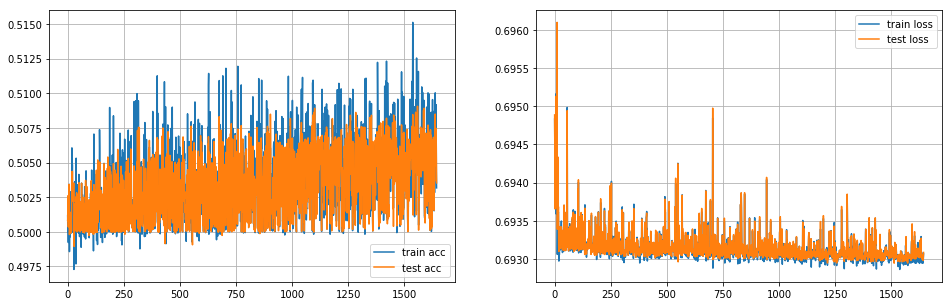

In [349]:
while epochs_completed < n_epochs:

    batch_i += 1
    x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = next_batch(batch_size)
    ycs_feed = dict(zip(yc_mi, ycs))
    yrs_feed = dict(zip(yr_mi, yrs))
    sess.run([train_step_mi], feed_dict= \
       {**ycs_feed,**yrs_feed, \
        **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb, xrsl_mi: xrsl_mb, \
           x_pastelo_mi: x_pastelo_mb, keep_prob_mi: dropout_keep_prob, rnn_kp: dropout_rnn}})
    sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')
#     writer.add_summary(s, batch_i)

    if batch_i % log_period_batches == 0:
        indices = np.random.choice(n_train, n_train_test, replace=False)
        x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = \
            get_individuals(X_train, Xr_train, Xr_sl_train, X_pastelos_train, Yc_train, Yr_train, indices)
        ycs_feed = dict(zip(yc_mi, ycs))
        yrs_feed = dict(zip(yr_mi, yrs))
        train_l, train_a, train_he = sess.run([loss_mi, accuracy_mi, accuracy_high_elo_mi], feed_dict= \
            {**ycs_feed,**yrs_feed, \
             **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb, xrsl_mi: xrsl_mb, \
                x_pastelo_mi: x_pastelo_mb, keep_prob_mi: 1.0, rnn_kp: 1.0}})

        x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = \
            get_individuals(X_test, Xr_test, Xr_sl_test, X_pastelos_test, Yc_test, Yr_test)
        ycs_feed = dict(zip(yc_mi, ycs))
        yrs_feed = dict(zip(yr_mi, yrs))
        test_l, test_a, test_he, yc_preds = \
            sess.run([loss_mi, accuracy_mi, accuracy_high_elo_mi, Yc_outprobs_mi[0]], feed_dict= \
            {**ycs_feed,**yrs_feed, \
             **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb, xrsl_mi: xrsl_mb, \
                x_pastelo_mi: x_pastelo_mb, keep_prob_mi: 1.0, rnn_kp: 1.0}})

        train_loss += [ train_l ]
        train_accuracy += [ train_a ]
        test_loss += [ test_l ]
        test_accuracy += [ test_a ]

        if test_a > best_acc:
            best_acc = test_a
            best_acc_he = test_he
            best_acc_tr = train_a
            best_preds = yc_preds
            best_i = np.argmax(test_accuracy)
            saver.save(sess, "./models/" + model_name + '/' + model_name)

        clear_output()
        print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
              "Best test acc res:", best_acc_tr, best_acc, best_acc_he, best_i)
        fig = plt.figure()
        fig.set_size_inches(16, 5)
        g = fig.add_subplot(1,2,1)
        g.grid()
        g.plot(train_accuracy, label='train acc')
        g.plot(test_accuracy, label='test acc')
        g.legend(loc='lower right')

        g = fig.add_subplot(1,2,2)
        g.grid()
        g.plot(train_loss, label='train loss')
        g.plot(test_loss, label='test loss')
        g.legend(loc='upper right')

        save_ld((train_accuracy, test_accuracy, train_loss, test_loss, best_preds),
                "model_logs/" + model_name + '_log_latest', pad=False)
        graphs_folder = "graphs"
        create_folder(graphs_folder)
        plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
        plt.show()

# Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [ ]:
# Predict for the first 1000 test samples, for each time t from 0 to 120 mins after the last match, and save the t
# for when the player actually played the next game (even if it's beyond 120 mins later). Use 15 second intervals

In [326]:
tod_scale, tod_offs = X_scalesdict["time_of_day"]
todx_idx = X_labels.index("time_of_day")
((((x_mb[:, X_inf_labels.index("time_of_day")] * scaler.scale_[todx_idx]) + \
   scaler.center_[todx_idx]) * tod_scale) + tod_offs) / (60*60)
tod_sc1 = scaler.scale_[todx_idx]
tod_ce1 = scaler.center_[todx_idx]
tod_sc2 = tod_scale
tod_ce2 = tod_offs
def adjust_tod(x_tod, offs):
    return (((((((((x_tod * tod_sc1) + tod_ce1) * tod_sc2) + tod_ce2) + offs) % (24 * 60 * 60)) \
              - tod_ce2) / tod_sc2) - tod_ce1) / tod_sc1

In [412]:
n_ = 1000
t_max = 30 * 24 * 60 * 60
t_interval = 60 * 60 # seconds
batch_idx = np.arange(0, n_)
pl_idx = np.tile(np.arange(N_PL), n_ // N_PL)
x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = \
    get_individuals(X_test, Xr_test, Xr_sl_test, X_pastelos_test, Yc_test, Yr_test, batch_idx, pl_idx)
ycs_feed = dict(zip(yc_mi, ycs))
yrs_feed = dict(zip(yr_mi, yrs))
tsinc_idx = X_rec_labels.index("time_since_match")
# tod_idx = X_inf_labels.index("time_of_day")
# For each of 120 * 60 / 15 = 480 time steps, create the corresponding xr_mb, and predict
curr_tsinc = xr_mb[np.arange(n_), xrsl_mb.astype(int) - 1, np.tile(tsinc_idx, n_)]
step_max = t_max // t_interval
inf_res = np.empty((n_, step_max))
pr_str_end = " / " + str(step_max)
for i in range(step_max):
    xr_mb_ = deepcopy(xr_mb)
#     x_mb_ = deepcopy(x_mb)
    new_t = i * t_interval
    for j in range(len(xr_mb_)):
        xr_mb_[j, :xrsl_mb[j].astype(int), tsinc_idx] -= curr_tsinc[j] - new_t
#     x_mb_[:, tod_idx] = adjust_tod(x_mb_[:, tod_idx], -(curr_tsinc - new_t))
    yc_preds = sess.run(Yc_outprobs_mi[0], feed_dict= \
        {**ycs_feed,**yrs_feed, \
         **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb_, xrsl_mi: xrsl_mb, \
            x_pastelo_mi: x_pastelo_mb, keep_prob_mi: 1.0, rnn_kp: 1.0}})
    inf_res[:, i] = yc_preds[:, 1]
    sys_print("\r" + str(i + 1) + pr_str_end)
save_ld((inf_res, curr_tsinc, x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs, meta[:n_], X_labels, X_rec_labels),
        "model_logs/mtmTest_retention.data", pad=False)

720 / 720

True True     17 7     17 21.94 2221.6 TR1
(   array([69.43333333, 68.81666667, 67.7       , 67.25      , 66.5       ,
       65.8       , 65.35      , 64.55      , 63.73333333, 63.1       ,
        3.83333333,  3.31666667,  2.7       ,  2.03333333,  1.21666667,
        0.48333333,  0.1       ]),
    array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]),
    [   [0, 2, 0],
        [10, 3, 9],
        [1, 7, 24],
        [1, 0, 11],
        [6, 8, 10],
        [0, 5, 14],
        [0, 2, 5],
        [2, 4, 17],
        [14, 3, 7],
        [6, 3, 10],
        [0, 10, 5],
        [1, 8, 6],
        [3, 6, 17],
        [3, 6, 6],
        [5, 13, 12],
        [2, 10, 15],
        [0, 4, 5]],
    'support')


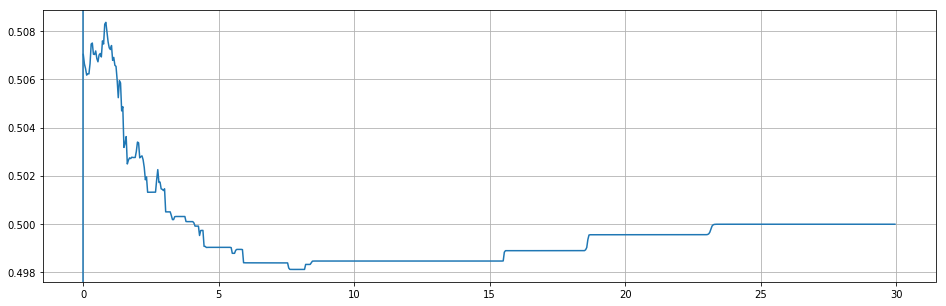

In [413]:
tst_i = 8
xr_mb_rel = xr_mb[tst_i, :xrsl_mb[tst_i].astype(int)]
tod = xr_mb_rel[-1, X_rec_labels.index("time_of_day")] / (60*60)
n_3days = sum(xr_mb[tst_i, :xrsl_mb[tst_i].astype(int), tsinc_idx] < (24*60*60) * 3)
n_1days = sum(xr_mb[tst_i, :xrsl_mb[tst_i].astype(int), tsinc_idx] < (24*60*60) * 1)
print(n_3days >= 10,
      n_1days >= 3,
      '   ', n_3days, n_1days,
      '   ', xrsl_mb[tst_i].astype(int), tod.round(2),
      meta[tst_i, meta_labels.index("elo")], rito_regions[meta[tst_i, meta_labels.index("region_id")].astype(int)])
pr((xr_mb_rel[:, tsinc_idx].round() // (60) / 60,
  xr_mb_rel[:, X_rec_labels.index("win")].astype(int),
  xr_mb_rel[:, [X_rec_labels.index("kills"), X_rec_labels.index("deaths"), X_rec_labels.index("assists")]].astype(int).tolist(),
  roles_all[x_role_mb[tst_i]]))
fig = plt.figure()
fig.set_size_inches(16, 5)
# plt.plot(np.arange(len(inf_res[tst_i])) * (15/60), inf_res[tst_i])
plt.plot((np.arange(len(inf_res[tst_i])) * (t_interval/(60*60*24))) , inf_res[tst_i])
plt.axvline(x=(curr_tsinc[tst_i] / (60*60*24)))# + (tod - (24 if tod > 12 else 0)))
plt.grid()
plt.show()

In [551]:
n_ = 1000
t_max = 24 * 60 * 60
t_interval = 60  # seconds
t_retro = 5 * 60 * 60  # seconds into the past to probe
batch_idx = np.arange(0, n_)
pl_idx = np.tile(np.arange(N_PL), n_ // N_PL)
x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = \
    get_individuals(X_test, Xr_test, Xr_sl_test, X_pastelos_test, Yc_test, Yr_test, batch_idx, pl_idx)
ycs_feed = dict(zip(yc_mi, ycs))
yrs_feed = dict(zip(yr_mi, yrs))
tsinc_idx = X_rec_labels.index("time_since_match")
dur_idx = X_rec_labels.index("duration")
# tod_idx = X_inf_labels.index("time_of_day")
# For each of 120 * 60 / 15 = 480 time steps, create the corresponding xr_mb, and predict
curr_tsinc = xr_mb[np.arange(n_), xrsl_mb.astype(int) - 1, np.tile(tsinc_idx, n_)]
step_max = t_max // t_interval
inf_res = np.empty((n_, step_max))
pr_str_end = " / " + str(step_max)
for i in range(step_max):
    xr_mb_ = deepcopy(xr_mb)
    xrsl_mb_ = deepcopy(xrsl_mb)
#     x_mb_ = deepcopy(x_mb)
    new_t = i * t_interval
    for j in range(len(xr_mb_)):
        xr_mb_[j, :xrsl_mb_[j].astype(int), tsinc_idx] -= (curr_tsinc[j] + t_retro) - new_t
        n_future = sum(xr_mb_[j, :xrsl_mb_[j].astype(int), tsinc_idx] < 0)
        xrsl_mb_[j] -= n_future
        if xrsl_mb_[j] < 1:
            xrsl_mb_[j] = 1
            xr_mb_[j, :] = 0
#     x_mb_[:, tod_idx] = adjust_tod(x_mb_[:, tod_idx], -(curr_tsinc - new_t))
    yc_preds = sess.run(Yc_outprobs_mi[0], feed_dict= \
        {**ycs_feed,**yrs_feed, \
         **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb_, xrsl_mi: xrsl_mb_, \
            x_pastelo_mi: x_pastelo_mb, keep_prob_mi: 1.0, rnn_kp: 1.0}})
    inf_res[:, i] = yc_preds[:, 1]
    sys_print("\r" + str(i + 1) + pr_str_end)
save_ld((inf_res, curr_tsinc, x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs, meta[:n_], X_labels, X_rec_labels),
        "model_logs/mtmTest.data", pad=False)

1440 / 1440

In [718]:
ycs[0][:, 1].shape

(1000,)

678      True True     15 8     15 2.64 644.6 EUW1
(   array([10.55      ,  9.83333333,  7.83333333,  7.13333333,  6.45      ,
        5.98333333,  5.36666667,  4.8       ,  4.03333333,  3.31666667,
        2.6       ,  1.96666667,  1.46666667,  0.83333333,  0.11666667]),
    array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]),
    [   [1.0, 7.0, 4.0, 1.7],
        [3.0, 2.0, 11.0, 2.2],
        [1.0, 1.0, 16.0, 2.1],
        [1.0, 4.0, 11.0, 2.0],
        [1.0, 5.0, 14.0, 2.9],
        [0.0, 4.0, 5.0, 0.5],
        [0.0, 5.0, 6.0, 4.0],
        [1.0, 5.0, 10.0, 0.3],
        [2.0, 5.0, 30.0, 0.6],
        [1.0, 4.0, 24.0, 0.4],
        [0.0, 5.0, 16.0, 0.3],
        [2.0, 4.0, 3.0, 0.5],
        [0.0, 3.0, 17.0, 1.0],
        [0.0, 9.0, 15.0, 0.7],
        [3.0, 7.0, 13.0, 1.4]],
    'support')


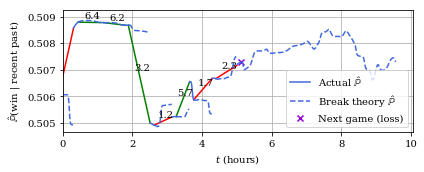

In [1009]:
for i in range(tst_i + 1, len(xr_mb)):
    n_3days = sum(xr_mb[i, :xrsl_mb[i].astype(int), tsinc_idx] < (24*60*60) * 2)
    n_1days = sum(xr_mb[i, :xrsl_mb[i].astype(int), tsinc_idx] < (5*60*60) * 1)
    if n_3days >= 10 and n_1days >= 5:# and meta[i, meta_labels.index("elo")] <= 2400 and meta[i, meta_labels.index("elo")] >= 700:
        tst_i = i
        break
xr_mb_rel = xr_mb[tst_i, :xrsl_mb[tst_i].astype(int)]
tod = xr_mb_rel[-1, X_rec_labels.index("time_of_day")] / (60*60)
n_3days = sum(xr_mb[tst_i, :xrsl_mb[tst_i].astype(int), tsinc_idx] < (24*60*60) * 3)
n_1days = sum(xr_mb[tst_i, :xrsl_mb[tst_i].astype(int), tsinc_idx] < (5*60*60) * 1)
print(tst_i, '    ',
      n_3days >= 10,
      n_1days >= 3,
      '   ', n_3days, n_1days,
      '   ', xrsl_mb[tst_i].astype(int), tod.round(2),
      meta[tst_i, meta_labels.index("elo")], rito_regions[meta[tst_i, meta_labels.index("region_id")].astype(int)])
pr((xr_mb_rel[:, tsinc_idx].round() // (60) / 60,
  xr_mb_rel[:, X_rec_labels.index("win")].astype(int),
  xr_mb_rel[:, [X_rec_labels.index("kills"),
                X_rec_labels.index("deaths"),
                X_rec_labels.index("assists"),
                X_rec_labels.index("creep_score_per_second"),
               ]].round(2).tolist(),
  roles_all[x_role_mb[tst_i]]))

kda_idx = X_rec_labels.index("kda_ratio")
win_idx = X_rec_labels.index("win")
tst_res = inf_res[tst_i]
graph_ts = np.arange(len(tst_res)) * (t_interval/(60*60))
retro_games = []
for i in range(len(xr_mb_rel)):
    gm = xr_mb_rel[i]
    end_t = (t_retro - gm[tsinc_idx]) + curr_tsinc[tst_i]# + (gm[dur_idx])# + (20*60)
    start_t = end_t - gm[dur_idx]
    if end_t > 0:
        start_t /= (60*60)
        end_t /= (60*60)
        start_i = get_nearest(graph_ts, start_t, direction='up', idx=True)
        end_i = get_nearest(graph_ts, end_t, direction='up', idx=True)
        kda = gm[kda_idx]
        win = gm[win_idx]
        
        start_p = tst_res[start_i]
        end_p = tst_res[end_i]
        retro_games.append([start_i, end_i, start_t, end_t, start_p, end_p, kda, win])

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig = plt.figure()
fig.set_size_inches(6, 2.5)
# plt.plot(np.arange(len(inf_res[tst_i])) * (15/60), inf_res[tst_i])
# plt.plot(graph_ts[:len(graph_ts)//3], tst_res[:len(graph_ts)//3])
# graph_ts = graph_ts[:len(graph_ts)//3]
# tst_res = tst_res[:len(graph_ts)//3]
max_i = int(len(graph_ts) / 2.5)
mtm_segs = []
mtm_pr_segs = []
cur_mtm_i = 0
for (start_i, end_i, start, end, start_p, end_p, kda, win) in retro_games:
    if start_i > 0:
        mtm_segs.append((graph_ts[max(0, cur_mtm_i-1):start_i + 1], tst_res[max(0, cur_mtm_i-1):start_i + 1]))
        if len(tst_res[cur_mtm_i:start_i + 1]) == 0:
            print(cur_mtm_i, start_i, len(tst_res))
    mtm_pr_segs.append((graph_ts[start_i:end_i + 1], tst_res[start_i:end_i + 1]))
    cur_mtm_i = end_i + 1
    plt.plot([start, end], [start_p, end_p], color="g" if win else 'r')
    plt.annotate(str(kda.round(1)),
                 xy=(((start + end) / 2) - 0.15, (((start_p + end_p) / 2)) + 0.00015))
# print(mtm_segs)
x_final = (curr_tsinc[tst_i] / (60*60)) + (t_retro / (60*60))
final_i = get_nearest(graph_ts, x_final, idx=True)
mtm_segs.append((graph_ts[cur_mtm_i:final_i], tst_res[cur_mtm_i:final_i]))
mtm_pr_segs.append((graph_ts[final_i:max_i], tst_res[final_i:max_i]))
i_ = 0
for (xs, ys) in mtm_segs:
    i_ += 1
    kwargs = {"label":"Inter-match"} if i_ == 1 else {}
    plt.plot(xs, ys, color="royalblue", **kwargs)
# print(mtm_pr_segs)
i_ = 0
for (xs, ys) in mtm_pr_segs:
    i_ += 1
    kwargs = {"label":"Break theory"} if i_ == 1 else {}
    plt.plot(xs[:-1], ys[:-1], color="royalblue", ls='--', **kwargs)
# plt.axvline(x=(curr_tsinc[tst_i] / (60*60)) + (t_retro / (60*60)))# + (tod - (24 if tod > 12 else 0)))
plt.scatter([x_final], [tst_res[final_i]],
            color='darkviolet', marker='x', label="Next game (" + ('win' if ycs[0][tst_i, 1] else 'loss') + ')')
    # + (tod - (24 if tod > 12 else 0)))
plt.grid()
plt.title("First approximation to a temporal win% momentum model")
plt.xlabel("$t$ (hours)")
plt.ylabel("$\hat{\mathbb{P}}$(win | recent past)")
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim((0, xlim[1]))
# plt.ylim((ylim[0], 0.50925))
# plt.legend(loc='lower right')
fig.tight_layout()
plt.savefig(graphs_folder + '/mtm_vs_time_1.pdf', format='pdf')
plt.show()

In [1008]:
tst_i = 677

In [ ]:
487 for tilt
511 for mtm
678 for both

In [ ]:
31?, 38, 53?, 62, 108?, 329?, 403?, 487, 511 (+), 522?, 678, 818?, 889?, 898, 911, 912?, 

In [ ]:
# Same model but no transfer learning (fresh cell & weights)

In [19]:
model_name = "influence_rnn_0transf"
blue_win_i_mi = Yc_targs.index("win")
train_set_test_frac = 0.05  # Get training accuracy for random 20% subset of train set
log_period_batches = 250
n_epochs = 100
learning_rate_amsgrad = 1.0 * 1e-4
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_sgd = 0.01
# regr_loss_ratio_mi = 1.0 * 1e-2
dropout_keep_prob_mi = 0.67
dropout_rnn_mi = 0.55
batch_size_mi = 256
lstm_forget_bias_mi = 1.0
c_type_mi = "GRU"

# pre_rnn1_units = 256
# # pre_rnn2_units = 256
# # pre_rnn3_units = 256
# # pre_rnn_shared_units = 256
# n_rnn_units = 256
# n_rnn_stacked = 1
# post_rnn_units = 256
pre_join_x_units_mi = 512
l1_n_units_mi = 512
l2_n_units_mi = 512
# l3_n_units = 512
# l4_n_units = 512
# l5_n_units = 512
# l6_n_units = 512
# final_layer_units = 512

# Define next batch function
miniepoch_i, current_i, epochs_completed = 0, 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)
pl_ordering = np.asarray([np.random.choice(10, 10, replace=False) for _ in range(n_train)])
def _get_individuals(X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx, pl_idx):
    x_mb = X___d[batch_idx, np.asarray([history_feat_idx[pl_idx[i]] for i in range(len(batch_idx))]).T].T
#     x_mb = np.asarray([X___d[batch_idx[i], history_feat_idx[pl_idx[i]]].T for i in range(len(batch_idx))])
    x_role_mb = (pl_idx % 5).astype(np.int32)
    xr_mb = np.asarray([Xr___d[pl_idx[i]][batch_idx[i]] for i in range(len(batch_idx))])
    xrsl_mb = np.asarray([Xr_sl___d[pl_idx[i]][batch_idx[i]] for i in range(len(batch_idx))])
    x_pastelo_mb = X_pastelos___d[batch_idx, pl_idx]    
    ycs = [Yc_[batch_idx] for Yc_ in Yc___d]
    yrs = np.asarray([[Yr___d[j][batch_idx[i]] for j in Yr_idx[pl_idx[i]]] for i in range(len(batch_idx))])
    yrs = [yrs[:, i] for i in range(yrs.shape[1])]
    # If red side, invert win
    red_is = np.nonzero(pl_idx >= 5)[0]
    if len(red_is) > 0:
        ycs[blue_win_i][red_is] = 1 - ycs[blue_win_i][red_is]
    return x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs
def get_individuals(X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx=None, pl_idx=None):
    if batch_idx is None:                              # Use full set
        batch_idx = np.arange(X___d.shape[0])
    if pl_idx is None:                                 # Use all players in each match
        pl_ord = np.tile(np.arange(N_PL), (min(X___d.shape[0], len(batch_idx)), 1))
        result = []
        for j in N_PL_r:
            result.append(list(_get_individuals(
              X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx, pl_ord[:, j])))
        return tuple([np.concatenate(res_) for res_ in list(zip(*result))[:-2]] + \
                     [[np.concatenate([res[-2][i] for res in result]) for i in range(len(result[0][-2]))]] + \
                     [[np.concatenate([res[-1][i] for res in result]) for i in range(len(result[0][-1]))]])
    return _get_individuals(X___d, Xr___d, Xr_sl___d, X_pastelos___d, Yc___d, Yr___d, batch_idx, pl_idx)
def next_batch(sz):
    global epoch_shuf, pl_ordering, miniepoch_i, current_i, epochs_completed
    batch_idx = epoch_shuf[current_i:current_i + sz]
    pl_idx = pl_ordering[current_i:current_i + sz, miniepoch_i]
    res = get_individuals(X_train, Xr_train, Xr_sl_train, X_pastelos_train, Yc_train, Yr_train, batch_idx, pl_idx)
    
    current_i += sz
    if current_i >= n_train:
        current_i = 0
        miniepoch_i += 1
        if miniepoch_i >= N_PL:
            miniepoch_i = 0
            epochs_completed += 1
            np.random.shuffle(epoch_shuf)
            pl_ordering = np.asarray([np.random.choice(10, 10, replace=False) for _ in range(n_train)])
    return res

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

def beta_swish(x):
    beta = tf.Variable(initial_value=1.0, trainable=True, name='swish-beta')
    return x * tf.nn.sigmoid(beta * x)
def swish(x):
    return x * tf.nn.sigmoid(x)
def autolog(x, x_min, n_feats, alpha=None, beta=None, gamma=None):
    with tf.name_scope("autolog"):
        if alpha is None: alpha = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-alpha')
        if beta is None:  beta  = tf.Variable(np.tile(0.4, n_feats).astype(np.float32), trainable=True, name='autolog-beta')
        if gamma is None: gamma = tf.Variable(np.tile(0.1, n_feats).astype(np.float32), trainable=True, name='autolog-gamma')
#         alpha = tf.constant(0.1, name='autolog-alpha')
#         beta = tf.constant(0.4, name='autolog-beta')
#         gamma = tf.constant(0.1, name='autolog-gamma')
        act = (alpha * x)
        act += tf.math.log(beta * (tf.clip_by_value(gamma, 1e-4, np.inf) + tf.clip_by_value(x - x_min, 0, np.inf)))
        tf.summary.histogram("autolog_alpha", alpha)
        tf.summary.histogram("autolog_beta", beta)
        tf.summary.histogram("autolog_gamma", gamma)
        tf.summary.histogram("autolog_activation", act)
        return act

x_mi = tf.placeholder(tf.float32, [None, n_features_history], name='x_history_mi')
x_role = tf.placeholder(tf.int32, [None], name='x_role_mi')
xr_mi = tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_rnn_mi")
xrsl_mi = tf.placeholder(tf.int32, [None], name="seq_len_mi")
x_pastelo_mi = tf.placeholder(tf.float32, [None], name="x_pastelo_mi")
yc_mi = [tf.placeholder(tf.float32, [None, 2], name="win")]
yr_mi = [tf.placeholder(tf.float32, [None, 1], name=l + '_mi') for l in Yr_targs]
keep_prob_mi = tf.placeholder(tf.float32, name="dropoutKeepProb_mi")
rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb_mi")

n_champions = len(champ_dict)
n_input_feats_mi = n_features_history + 5
# n_input_feats_mi = 5

with tf.name_scope("mi_model"):
    bnorm_counter_mi = -1
    def bnorm_appl_mi(inp):
        global bnorm_counter_mi
        bnorm_counter_mi += 1
        return dropout(bnorm(inp, name="mi_model_Bnorm_" + str(bnorm_counter_mi)), \
                       keep_prob_mi, name="mi_model_Dropout_" + str(bnorm_counter_mi))
    with tf.name_scope("metadata_mi"):
    #     b_size = tf.shape(x)[0]
        x_reg_mi = tf.gather(x_mi, X_reg_idx, axis=1)
    
        # First, group recurrent input by role
        role_idx = [tf.squeeze(tf.where(tf.equal(x_role, i))) for i in range(5)]
        stacked_roles = tf.concat(role_idx, axis=0)
        recovery_idx = tf.contrib.framework.argsort(stacked_roles, stable=True)
        xr_grp = [tf.gather(xr_mi, role_idx[i], axis=0) for i in range(5)]
        xrsl_grp = [tf.gather(xrsl_mi, role_idx[i], axis=0) for i in range(5)]
        x_reg_grp = [tf.gather(x_reg_mi, role_idx[i], axis=0) for i in range(5)]
        x_pastelo_grp = [tf.gather(tf.expand_dims(x_pastelo_mi, 1), role_idx[i], axis=0) for i in range(5)]

    with tf.name_scope("past_games_mi"):
    #     xr_sc_mi = (xr_mi - rec_median) / rec_iqr
        # Scale data
        xr_stacked_mi = [autolog(tf.reshape(xr_grp[i], [-1, n_rec_features]), Xr_mins[i], n_rec_features,
                                  ) for i in range(5)]

    with tf.name_scope("recurrent_mi"):
       # Construct pre-rnn layers
        with tf.name_scope("pre_rnn_fc_mi"):
            Xr_Wp1s_mi = [tf.Variable(izer([n_rec_features, pre_rnn1_units])) for r in roles_all]
            Xr_bp1s_mi = [tf.Variable(izer([pre_rnn1_units])) for r in roles_all]
            pre_l_1_mi = [tf.matmul(xr_stacked_mi[i], Xr_Wp1s_mi[i]) + Xr_bp1s_mi[i] for i in range(5)]
            pre_ls_mi = [tf.reshape(pre_l_1_mi[i], [-1, rec_max_len, pre_rnn1_units]) for i in range(5)]

        with tf.name_scope("rnn_mi"):
            def get_rnn_cell(c_type, lstm_forget_bias, kp):
              cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
                     rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell")
              return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
            if n_rnn_stacked > 1:
            #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
                cell_mi = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
            else:
            #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
                cell_mi = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)
            W_begin_token_mi = [tf.Variable(izer([len(X_reg_idx) + 1, n_rnn_units])) for r in roles_all]
            b_begin_token_mi = [tf.Variable(izer([n_rnn_units])) for r in roles_all]
            x_token_mi = [tf.concat([x_reg_grp[i], x_pastelo_grp[i]], axis=1) for i in range(5)]
            init_states_mi = [tf.matmul(x_token_mi[i], W_begin_token_mi[i]) + b_begin_token_mi[i] for i in range(5)]
            rnn_os_mi, _ = zip(*[tf.nn.dynamic_rnn(cell_mi, pre_ls_mi[i],
                                        sequence_length=xrsl_grp[i], initial_state=init_states_mi[i],
                                        dtype=tf.float32) for i in range(5)])
            rnn_outs_mi = [tf.gather_nd(rnn_os_mi[i],
                           tf.stack([tf.range(tf.shape(rnn_os_mi[i])[0]), xrsl_grp[i] - 1], axis=1)) for i in range(5)]

        with tf.name_scope("post_rnn_fc_mi"):
            Xr_W1s_mi = [tf.Variable(izer([n_rnn_units, post_rnn_units])) for r in roles_all]
            Xr_b1s_mi = [tf.Variable(izer([post_rnn_units])) for r in roles_all]
            Xr_W2s_mi = tf.Variable(izer([post_rnn_units, l1_n_units_mi]))
            post_rnn_layers_mi=[bnorm_appl_mi(leaky_relu(tf.matmul(rnn_outs_mi[i],Xr_W1s_mi[i])+Xr_b1s_mi[i])) for i in range(5)]
            post_rnn_layer_mi = tf.gather(tf.concat(post_rnn_layers_mi, axis=0), recovery_idx, axis=0)  # Reassemble batch
            rnn_output = bnorm_appl_mi(tf.matmul(post_rnn_layer_mi, Xr_W2s_mi))

    with tf.name_scope("player_history_mi"):
        x_input_hist = autolog(x_mi, X_mins_mi, n_features_history)

    with tf.name_scope("fully_connected_mi"):
        x_input_mi = tf.concat([x_input_hist, tf.one_hot(x_role, 5)], axis=1)
#         x_input_mi = tf.one_hot(x_role, 5)
    
        Wp_1_mi = tf.Variable(izer([n_input_feats_mi, pre_join_x_units_mi]), name='W_xin_linear')
        bp_1_mi = tf.Variable(izer([pre_join_x_units_mi]), name='b_xin_linear')

        W_1_mi = tf.Variable(izer([pre_join_x_units_mi, l1_n_units_mi]), name='W_fc_1_relu')
        b_1_mi = tf.Variable(izer([l1_n_units_mi]), name='b_fc_1_relu')
        W_2_mi = tf.Variable(izer([l1_n_units_mi, l2_n_units_mi]), name='W_fc_2_linear')
        b_2_mi = tf.Variable(izer([l2_n_units_mi]), name='b_fc_2_linear')
        pre_join_x_mi = tf.matmul(x_input_mi, Wp_1_mi) + bp_1_mi

        relu_1_mi = leaky_relu(tf.matmul(pre_join_x_mi, W_1_mi) + b_1_mi + rnn_output)
        relu_2_mi = bnorm_appl_mi(tf.matmul(relu_1_mi, W_2_mi) + b_2_mi)
    #     relu_3 = bnorm_appl_mi(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
    #     relu_4 = bnorm_appl_mi(tf.matmul(relu_3, W_4) + b_4)

    with tf.name_scope("final_output_mi"):
        with tf.name_scope("output_W_mi"):
            Yc_W2s_mi = [tf.Variable(izer([l2_n_units_mi, n_outputs[i]]), name=Yc_targs[i]) for i in range(len(Yc_targs))]
            Yr_W2s_mi = [tf.Variable(izer([l2_n_units_mi, 1]), name=Yr_use[i]) for i in range(len(Yr_targs))]
        with tf.name_scope("output_b_mi"):
            Yr_b2s_mi = [tf.Variable(izer([1]), name=Yr_targs[i]) for i in range(len(Yr_targs))]
            Yc_b2s_mi = [tf.Variable(izer([n_outputs[i]]), name=Yc_targs[i]) for i in range(len(Yc_targs))]

        with tf.name_scope("classif_outs_mi"):
            Yc_outs_mi = [leaky_relu(tf.matmul(relu_2_mi, Yc_W2s_mi[i]) + Yc_b2s_mi[i]) for i in range(len(Yc_targs))]
            Yc_outprobs_mi = [tf.nn.softmax(Yc_outs_mi[i]) for i in range(len(Yc_targs))]
        with tf.name_scope("regr_outs_mi"):
            Yr_outs_mi = [leaky_relu(tf.matmul(relu_2_mi, Yr_W2s_mi[i]) + Yr_b2s_mi[i]) for i in range(len(Yr_targs))]

    # Define loss function & training step
    with tf.name_scope("loss_mi"):
        with tf.name_scope("classif_xent_loss_mi"):
            Yc_losses_mi = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                         labels=yc_mi[i], logits=Yc_outs_mi[i])) for i in range(len(Yc_targs))]
        with tf.name_scope("regr_l2_losses_mi"):
            Yr_losses_mi = [tf.reduce_mean(tf.nn.l2_loss(yr_mi[i] - Yr_outs_mi[i])) for i in range(len(Yr_targs))]
    #         loss = sum(Yc_losses_mi + [tf.reduce_mean(Yr_losses_mi)])
        loss_mi = sum(Yc_losses_mi)# + (regr_loss_ratio_mi * tf.reduce_mean(Yr_losses_mi))

    with tf.name_scope("train_mi"):
        mi_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "mi_model")
        train_step_mi = AMSGrad(learning_rate=learning_rate_amsgrad,
                                beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss_mi, var_list=mi_trainables)
        # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
    #     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

    with tf.name_scope("accuracy_mi"):
        # Define accuracy computation
        correct_mi = tf.cast(tf.equal(tf.argmax(Yc_outs_mi[blue_win_i_mi], 1), tf.argmax(yc_mi[blue_win_i_mi], 1)), tf.float32)
        accuracy_mi = tf.reduce_mean(correct_mi)
        accuracy_high_elo_mi = tf.reduce_mean(tf.gather(correct_mi, high_elo_test_is_mi))

tf.summary.scalar("loss_mi", loss_mi)
tf.summary.scalar("accuracy_mi", accuracy_mi)
merged_summary = tf.summary.merge_all()

# Train
batch_i = 0
best_i = 0
best_acc = 0
best_acc_tr = 0
best_acc_he = 0
best_preds = None
saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False) # comment this out if restoring train/test indices

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 53 : 0.52365714 0.5227301 0.51582015 loss: 0.6904663 0.6907665 Best test acc res: 0.52717143 0.5237784 0.5194005 579


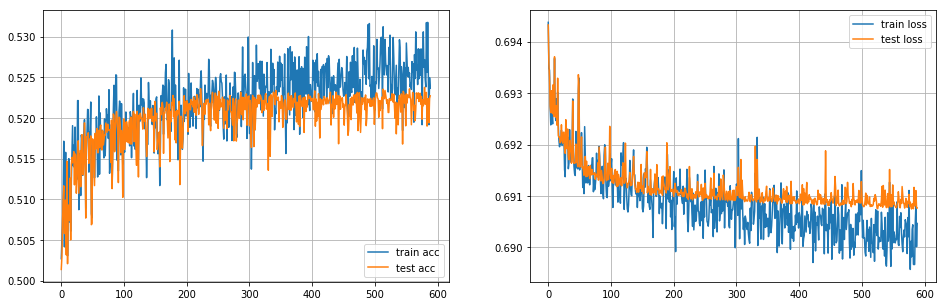

Batch 147494 (37758464 samples) complete

KeyboardInterrupt: 

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    create_folder("logs/tensorboard/" + model_name, overwrite=True)
    writer = tf.summary.FileWriter("logs/tensorboard/" + model_name)
    writer.add_graph(sess.graph)
    while epochs_completed < n_epochs:

        batch_i += 1
        x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = next_batch(batch_size)
        ycs_feed = dict(zip(yc_mi, ycs))
        yrs_feed = dict(zip(yr_mi, yrs))
        sess.run([train_step_mi], feed_dict= \
           {**ycs_feed,**yrs_feed, \
            **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb, xrsl_mi: xrsl_mb, \
               x_pastelo_mi: x_pastelo_mb, keep_prob_mi: dropout_keep_prob, rnn_kp: dropout_rnn}})
        sys_print('\rBatch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete')
    #     writer.add_summary(s, batch_i)

        if batch_i % log_period_batches == 0:
            indices = np.random.choice(n_train, n_train_test, replace=False)
            x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = \
                get_individuals(X_train, Xr_train, Xr_sl_train, X_pastelos_train, Yc_train, Yr_train, indices)
            ycs_feed = dict(zip(yc_mi, ycs))
            yrs_feed = dict(zip(yr_mi, yrs))
            train_l, train_a, train_he = sess.run([loss_mi, accuracy_mi, accuracy_high_elo_mi], feed_dict= \
                {**ycs_feed,**yrs_feed, \
                 **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb, xrsl_mi: xrsl_mb, \
                    x_pastelo_mi: x_pastelo_mb, keep_prob_mi: 1.0, rnn_kp: 1.0}})

            x_mb, x_role_mb, xr_mb, xrsl_mb, x_pastelo_mb, ycs, yrs = \
                get_individuals(X_test, Xr_test, Xr_sl_test, X_pastelos_test, Yc_test, Yr_test)
            ycs_feed = dict(zip(yc_mi, ycs))
            yrs_feed = dict(zip(yr_mi, yrs))
            test_l, test_a, test_he, yc_preds = \
                sess.run([loss_mi, accuracy_mi, accuracy_high_elo_mi, Yc_outprobs_mi[0]], feed_dict= \
                {**ycs_feed,**yrs_feed, \
                 **{x_mi: x_mb, x_role: x_role_mb, xr_mi: xr_mb, xrsl_mi: xrsl_mb, \
                    x_pastelo_mi: x_pastelo_mb, keep_prob_mi: 1.0, rnn_kp: 1.0}})

            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]

            if test_a > best_acc:
                best_acc = test_a
                best_acc_he = test_he
                best_acc_tr = train_a
                best_preds = yc_preds
                best_i = np.argmax(test_accuracy)
                saver.save(sess, "./models/" + model_name + '/' + model_name)

            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, test_he, "loss:", train_l, test_l, \
                  "Best test acc res:", best_acc_tr, best_acc, best_acc_he, best_i)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')

            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, test_accuracy, train_loss, test_loss, best_preds),
                    "model_logs/" + model_name + '_log_latest', pad=False)
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
            plt.show()

    # Result format: (train accuracy, test accuracy, high elo test accuracy), (training loss, testing loss)

In [245]:
_, _, _, _, preds = load_ld("model_logs/momentum_rnn_log.data", pad=False)
Y_ambiwin = np.tile(Yc_test[0], (10, 1))
Y_ambiwin[Y_ambiwin.shape[0] // 2:] = 1 - Y_ambiwin[Y_ambiwin.shape[0] // 2:]
np.mean(Y_ambiwin == np.round(preds))

0.5139547990756919

Epoch 9 : 0.51339287 0.5136505 0.508368 loss: 0.7175737 0.72398067 Best test acc res: 0.5181 0.51911175 0.50932556 155


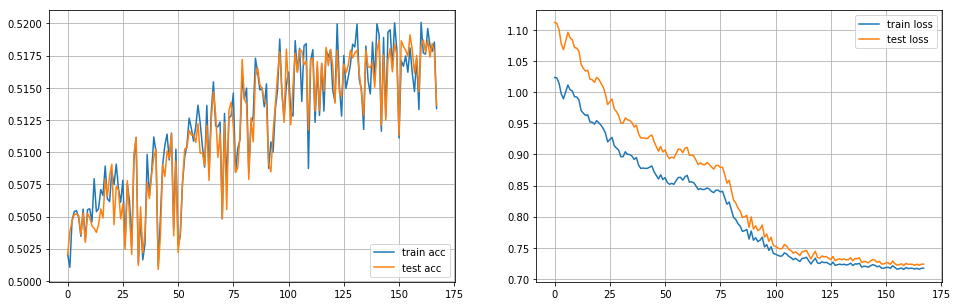

Batch 25000 (6400000 samples) complete

KeyboardInterrupt: 

In [186]:
# Influence model, includes regression targets, 3.5 * 10^-5  learning rate

Epoch 4 : 0.50357145 0.50239533 0.5022898 loss: 0.6959147 0.706432 Best test acc res: 0.5074 0.5064927 0.50345546 40


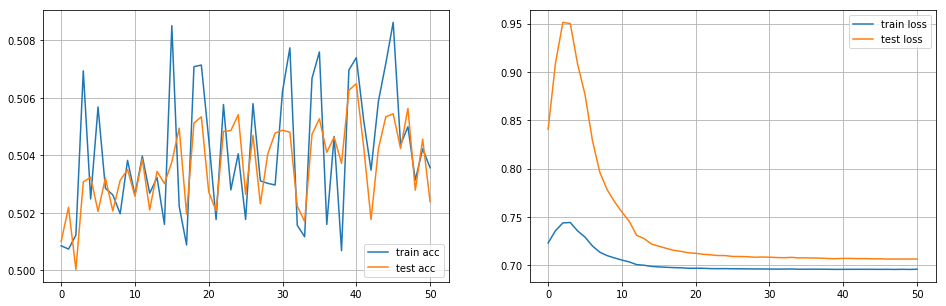

Batch 12821 (3282176 samples) complete

KeyboardInterrupt: 

In [207]:
# Momentum model, includes regression targets, 3.5 * 10^-4  learning rate

Epoch 4 : 0.50331426 0.50414246 0.5014571 loss: 0.69309175 0.69309455 Best test acc res: 0.509 0.5069661 0.50395507 45


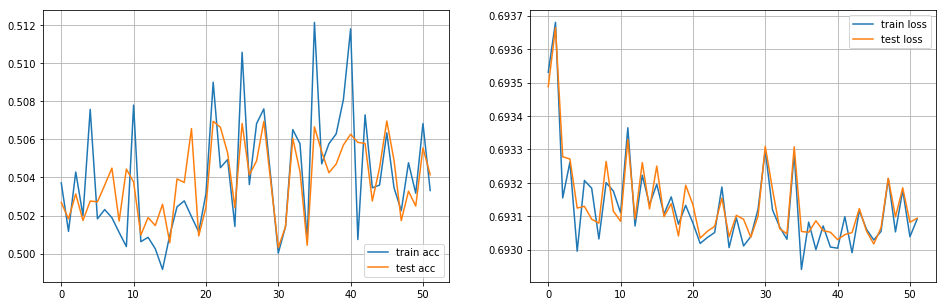

Batch 13119 (3358464 samples) complete

KeyboardInterrupt: 

In [216]:
# Momentum model, excludes regression targets, 3.5 * 10^-4  learning rate

Epoch 13 : 0.5112857 0.51096773 0.51111573 loss: 0.6923117 0.69242924 Best test acc res: 0.5148857 0.5139548 0.5086178 132


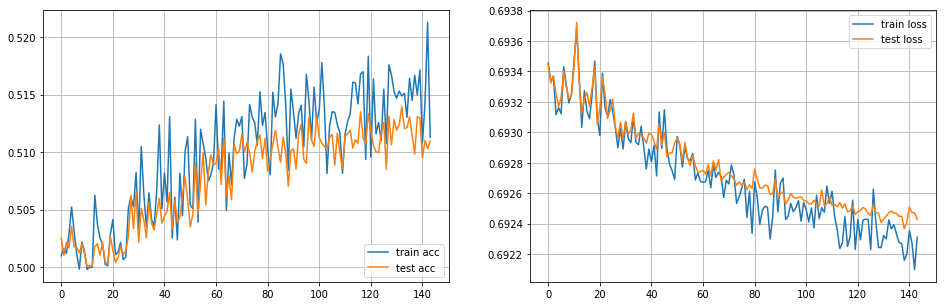

Batch 36077 (9235712 samples) complete

KeyboardInterrupt: 

In [236]:
# Fresh weights Momentum model, excludes regression targets, 1.0 * 1e-4

Epoch 9 : 0.51182854 0.51323336 0.5092423 loss: 0.6918215 0.69176894 Best test acc res: 0.5213714 0.52008677 0.5134471 80


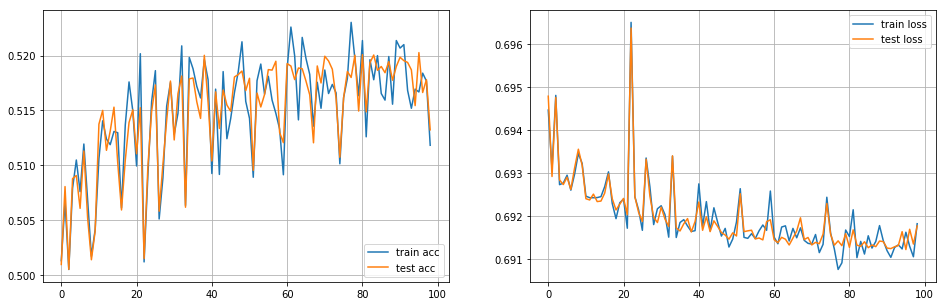

Batch 24770 (6341120 samples) complete

KeyboardInterrupt: 

In [248]:
# Fresh weights Influence model, excludes regression targets, 1.0 * 1e-4

Epoch 4 : 0.50214285 0.50339854 0.501582 loss: 0.69321907 0.69313824 Best test acc res: 0.5072857 0.50694925 0.5014155 34


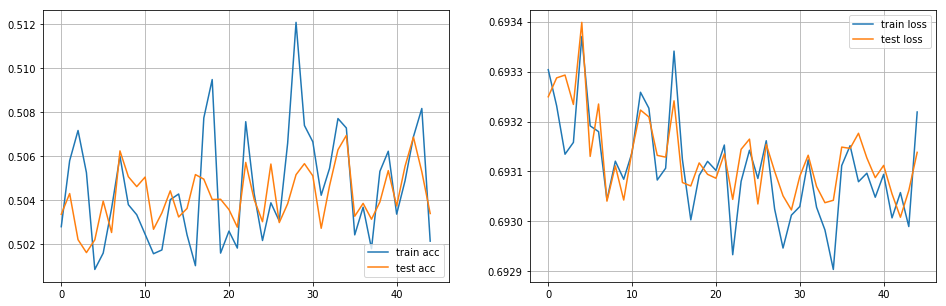

Batch 11336 (2902016 samples) complete

KeyboardInterrupt: 

In [257]:
# Momentum model, excludes regression targets, 1.0 * 1e-4

Epoch 53 : 0.52365714 0.5227301 0.51582015 loss: 0.6904663 0.6907665 Best test acc res: 0.52717143 0.5237784 0.5194005 579


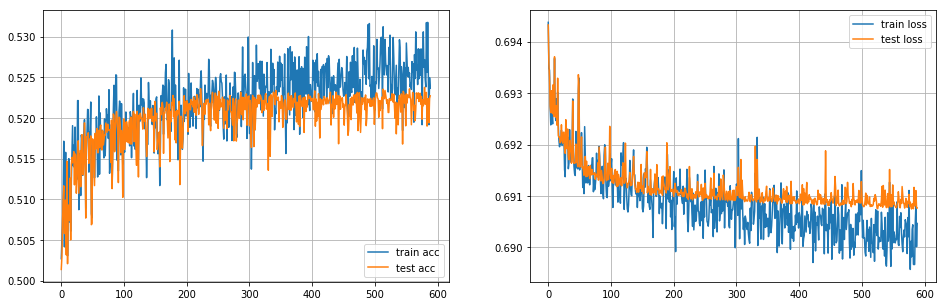

Batch 147494 (37758464 samples) complete

KeyboardInterrupt: 

Epoch 50 : 0.74785715 0.69875443 0.67194 loss: 0.75637025 0.8865681 Best test acc res: 0.727 0.71391535 0.6798501 361


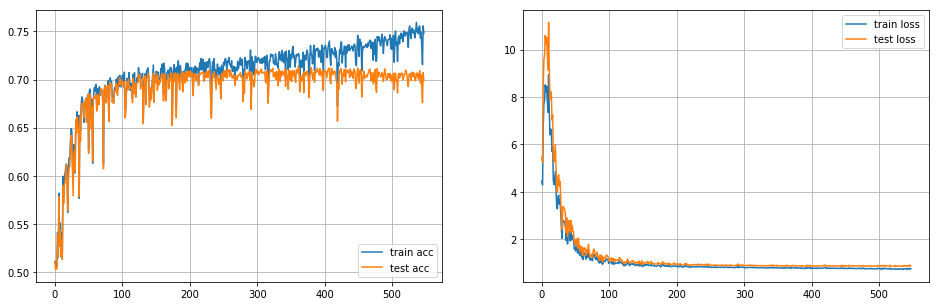

In [33]:
# orig result from thesis

Epoch 50 : 0.7335 0.70422137 0.67152375 loss: 0.767467 0.8705696 Best test acc res: 0.72735715 0.71233726 0.6773522 396


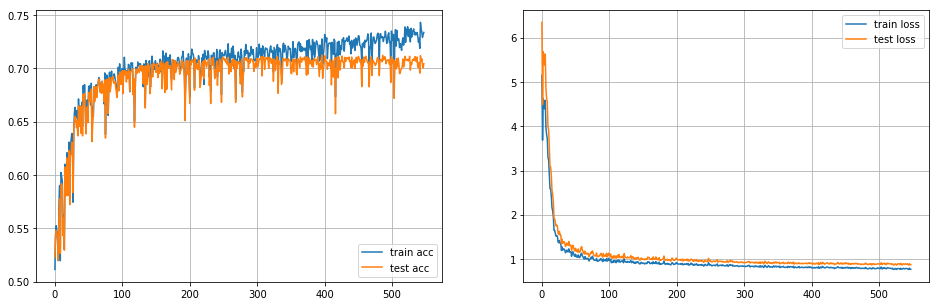

In [31]:
# some random result idk what from, probably not needed

Epoch 50 : 0.5300286 0.5242293 0.5178601 loss: 0.6898131 0.6907564 Best test acc res: 0.5300286 0.5242293 0.5178601 547


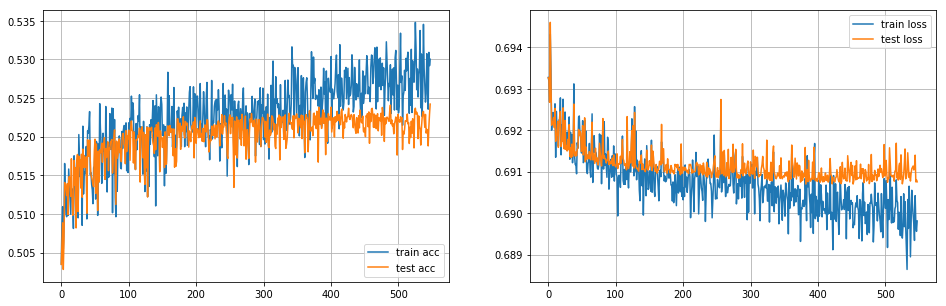

In [22]:
# influence TL most recent training

In [ ]:
# On second AutoLog tuning iteration, don't create a new session, just reset non-autolog parameters
# n_epochs += 1
# log_period_batches = 5
# n_total_batches = 0
# for i in range(250):
#     n_total_batches += log_period_batches
#     time.sleep(5)
#     sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "non_autolog")))
#     time.sleep(5)
#     train_iteration()

In [62]:
#cur best 64.2, 64.3, 64.39

In [316]:
model_name = "rnn_mt_tl"
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2  # Get training accuracy for random 20% subset of train set
log_period_batches = 25
n_epochs = 70
learning_rate_amsgrad = 3.5 * 1e-5
# learning_rate_adam = 3.5 * 1e-5
# learning_rate_sgd = 0.01
regr_loss_ratio = 1.0 * 1e-2
dropout_keep_prob = 0.67
dropout_rnn = 0.55
batch_size = 256
lstm_forget_bias = 1.0
c_type = "GRU" # "Vanilla", "LSTM"

pre_rnn1_units = 256
# pre_rnn2_units = 256
# pre_rnn3_units = 256
# pre_rnn_shared_units = 256
n_rnn_units = 256
n_rnn_stacked = 1
post_rnn_units = 256
pre_join_x_units = 2048
l1_n_units = 4096
l2_n_units = 4096
l3_n_units = 4096
l4_n_units = 4096
# l5_n_units = 4096
# l6_n_units = 4096
# final_layer_units = 4096

# Define next batch function
current_i, epochs_completed = 0, 0
epoch_shuf = np.arange(n_train)
np.random.shuffle(epoch_shuf)

n_train_test = int(train_set_test_frac * n_train)
# izer = tf.contrib.layers.xavier_initializer()
# tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

# x = tf.placeholder(tf.float32, [None, n_features], name='x')
# xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features], name="x_" + r + "_rnn") for r in t_roles]
# xrsl = [tf.placeholder(tf.int32, [None], name="seq_len_" + r) for r in t_roles]
# x_chmp = tf.placeholder(tf.int32, [None, N_PL], name="x_champions")
# x_ppos = tf.placeholder(tf.int32, [None, N_PL], name="x_pickPositions")
# x_spell1 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell1s")
# x_spell2 = tf.placeholder(tf.int32, [None, N_PL], name="x_spell2s")
# x_pastelo = tf.placeholder(tf.float32, [None, N_PL], name="x_pastelos")
# yc = [tf.placeholder(tf.float32, [None, n_outputs[i]], name=Yc_use[i] + "_labels") for i in range(len(Yc_targets))]
# yr = [tf.placeholder(tf.float32, [None, 1], name=(Yr_use[i] if f2(Yr_use[i]) not in t_roles else \
#         '_'.join(Yr_use[i].split('_')[2:] + [f2(Yr_use[i])])) + "_targets") for i in range(len(Yr_targets))]
# keep_prob = tf.placeholder(tf.float32, name="dropoutKeepProb")
# rnn_kp = tf.placeholder(tf.float32, name="rnnDropoutKeepProb")

n_champions = len(champ_dict)
# n_input_feats = n_features
# n_input_feats = n_features + (N_PL ** 2)
x_predraft = tf.gather(x, pre_draft_idx, axis=1)
X_mins_pd = X_mins[pre_draft_idx]

n_features_pd = len(pre_draft_idx)
n_input_feats_pd = n_features_pd
# n_input_feats_pd = n_features_pd + (n_champions * 2) + (N_PL ** 2) + (n_spells * N_PL)

# xr_alphas = [tf.Variable(np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_betas = [tf.Variable(np.tile(0.4, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_gammas = [tf.Variable(np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_alphas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_betas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.4, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# xr_gammas = [tf.Variable((izer([n_rec_features]) * 0.01) + np.tile(0.1, n_rec_features).astype(np.float32), trainable=True) for _ in roles_all]
# x_alpha = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)
# x_beta = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.4, n_features).astype(np.float32), trainable=True)
# x_gamma = tf.Variable((izer([n_features]) * 0.01) + np.tile(0.1, n_features).astype(np.float32), trainable=True)

# with tf.name_scope("metadata"):
# #     b_size = tf.shape(x)[0]
#     x_reg = tf.gather(x, X_reg_idx, axis=1)

# with tf.name_scope("past_games"):
# #     xr_sc = [(xr_ - rec_median) / rec_iqr for xr_ in xr]
#     xr_stacked = [autolog(tf.reshape(xr[i], [-1, n_rec_features]), \
#                   Xr_mins[i % 5], n_rec_features, xr_alphas[i % 5], xr_betas[i % 5], xr_gammas[i % 5]) for i in N_PL_r]
with tf.name_scope("recurrent"):
    # Construct pre-rnn layers
#     with tf.name_scope("pre_rnn_fc"):
# #         Xr_Wp1s = [tf.Variable(izer([n_rec_features, pre_rnn1_units]), name='W_rnn_pre_1_linear_' + r) for r in roles_all]
# #         Xr_bp1s = [tf.Variable(izer([pre_rnn1_units]), name='b_rnn_pre_1_linear_' + r) for r in roles_all]
#         # Xr_Wp2s = [tf.Variable(izer([pre_rnn1_units, pre_rnn2_units])) for _ in range(5)]
#         # Xr_bp2s = [tf.Variable(izer([pre_rnn2_units])) for _ in range(5)]
#         # Xr_Wp3s = [tf.Variable(izer([pre_rnn2_units, pre_rnn3_units])) for _ in range(5)]
#         # Xr_bp3s = [tf.Variable(izer([pre_rnn3_units])) for _ in range(5)]
#         # Xr_Wp3s = tf.Variable(izer([pre_rnn2_units, pre_rnn_shared_units]))
#         # Xr_bp3s = tf.Variable(izer([pre_rnn_shared_units]))

#         pre_l_1 = [tf.matmul(xr_stacked[i], Xr_Wp1s[i % 5]) + Xr_bp1s[i % 5] for i in N_PL_r]
#         # pre_l_2 = [dropout(leaky_relu(tf.matmul(pre_l_1[i], Xr_Wp2s[i % 5]) + Xr_bp2s[i % 5]), keep_prob) for i in N_PL_r]
#         # pre_l_3 = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s[i % 5]) + Xr_bp3s[i % 5]), keep_prob) for i in N_PL_r]
#         # pre_l_shared = [dropout(leaky_relu(tf.matmul(pre_l_2[i], Xr_Wp3s) + Xr_bp3s), keep_prob) for i in N_PL_r]
#         pre_ls = [tf.reshape(pre_l_1[i], [-1, rec_max_len, pre_rnn1_units]) for i in N_PL_r]

#     with tf.name_scope("rnn"):
#         def get_rnn_cell(c_type, lstm_forget_bias, kp):
#           cell = rnn.GRUCell(n_rnn_units, name="rnn_cell") if c_type == "GRU" else \
#                 (rnn.BasicRNNCell(n_rnn_units, name="rnn_cell") if c_type == "Vanilla" else \
#                  rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias, name="rnn_cell"))
#           return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=kp)
#         if n_rnn_stacked > 1:
#         #     cells = [rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)]) for _ in range(5)]
#             cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(n_rnn_stacked)])
#         else:
#         #     cells = [get_rnn_cell(c_type, lstm_forget_bias, rnn_kp) for _ in range(5)]
#             cell = get_rnn_cell(c_type, lstm_forget_bias, rnn_kp)

# #         with tf.name_scope("rnn_beginToken_W"):
# # #             W_begin_token = [tf.Variable(izer([1, n_rnn_units])) for _ in range(5)]
# #             W_begin_token = [tf.Variable(izer([len(X_reg_idx) + 1, n_rnn_units]), name=r) for r in roles_all]
# #         with tf.name_scope("rnn_beginToken_b"):
# #             b_begin_token = [tf.Variable(izer([n_rnn_units]), name=r) for r in roles_all]

#         # Define rnn cell initial state
#         x_token = [tf.concat([x_reg, tf.gather(x_pastelo, [i], axis=1)], axis=1) for i in N_PL_r]
#         init_states = [tf.matmul(x_token[i], W_begin_token[i % 5]) + b_begin_token[i % 5] for i in N_PL_r]
# #         init_states = [tf.tile(W_begin_token[i], [tf.shape(xrsl[0])[0], 1]) for i in range(5)]
#         rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, pre_ls[i], sequence_length=xrsl[i], initial_state=init_states[i],
#                                     dtype=tf.float32) for i in N_PL_r])
#         # with tf.variable_scope("foo", reuse=tf.AUTO_REUSE) as vs:
#         #     rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cells[i % 5], pre_ls[i], sequence_length=xrsl[i],
#         #                                              scope=vs, dtype=tf.float32) for i in N_PL_r])
#         rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([tf.range(tf.shape(rnn_os[i])[0]), xrsl[i] - 1], axis=1)) for i in N_PL_r]

#     with tf.name_scope("post_rnn_fc"):
# #         Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
# #         Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
# #         Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
#         # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

#         post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
#         rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

    with tf.name_scope("post_rnn_fc"):
#         Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
#         # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

#         post_rnn_layers = [bnorm_appl(leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5])) for i in N_PL_r]
#         rnn_l1 = [bnorm_appl(tf.matmul(post_rnn_layers[i], Xr_W2s[i % 5])) for i in N_PL_r]  # Sum join

#     with tf.name_scope("post_rnn_fc"):
#         Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units]), name='W_rnn_post_1_relu_' + r) for r in roles_all]
#         Xr_b1s = [tf.Variable(izer([post_rnn_units]), name='b_rnn_post_1_relu_' + r) for r in roles_all]
        post_rnn_lin = [leaky_relu(tf.matmul(rnn_outs[i], Xr_W1s[i % 5]) + Xr_b1s[i % 5]) for i in N_PL_r]

with tf.name_scope("fmn"):
    bnorm_counter_tl = -1
    def bnorm_appl_tl(inp):
        global bnorm_counter_tl
        bnorm_counter_tl += 1
        return dropout(bnorm(inp, name="fmn_Bnorm_" + str(bnorm_counter_tl)), \
                       keep_prob, name="fmn_Dropout_" + str(bnorm_counter_tl))

    Xr_W2s_pd = [tf.Variable(izer([post_rnn_units, l1_n_units]), name='W_rnn_post_2_linear_' + r) for r in roles_all]
    # Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

    post_rnn_layers_pd = [bnorm_appl_tl(post_rnn_lin[i]) for i in N_PL_r]
    rnn_l1_pd = [bnorm_appl_tl(tf.matmul(post_rnn_layers[i], Xr_W2s_pd[i % 5])) for i in N_PL_r]  # Sum join

    x_alpha_pd = tf.Variable(np.tile(0.1, n_features_pd).astype(np.float32), trainable=True)
    x_beta_pd = tf.Variable(np.tile(0.4, n_features_pd).astype(np.float32), trainable=True)
    x_gamma_pd = tf.Variable(np.tile(0.1, n_features_pd).astype(np.float32), trainable=True)
    
    with tf.name_scope("team_compositions"):
        # Add champion compositions and pick positions
        x_champsum = tf.one_hot(x_chmp, n_champions)
        x_pposes = tf.one_hot(x_ppos, N_PL)
        x_ch_bsum = tf.reduce_sum(x_champsum[:, :5], axis=1)
        x_ch_rsum = tf.reduce_sum(x_champsum[:, 5:], axis=1)
        x_spellsum = tf.one_hot(x_spell1, n_spells) + tf.one_hot(x_spell2, n_spells)
#         x_input = autolog(x, X_mins, n_features, x_alpha, x_beta, x_gamma)
        x_input = autolog(x_predraft, X_mins_pd, n_features_pd, x_alpha_pd, x_beta_pd, x_gamma_pd)
#         x_input = tf.concat([autolog(x_predraft, X_mins_pd, n_features_pd, x_alpha_pd, x_beta_pd, x_gamma_pd),
#                              x_ch_bsum,
#                              x_ch_rsum,
#                              tf.reshape(x_pposes, [-1, N_PL ** 2]),
#                              tf.reshape(x_spellsum, [-1, N_PL * n_spells])], axis=1)
#                              tf.reshape(x_pposes, [-1, N_PL ** 2])], axis=1)

    with tf.name_scope("fully_connected"):
        Wp_1 = tf.Variable(izer([n_input_feats_pd, pre_join_x_units]), name='W_xin_linear')
        bp_1 = tf.Variable(izer([pre_join_x_units]), name='b_xin_linear')

        W_1 = tf.Variable(izer([pre_join_x_units, l1_n_units]), name='W_fc_1_relu')  # Sum join
        # W_1 = tf.Variable(izer([pre_join_x_units + (post_rnn_units * N_PL), l1_n_units]))  # Concat join
        b_1 = tf.Variable(izer([l1_n_units]), name='b_fc_1_relu')
        W_2 = tf.Variable(izer([l1_n_units, l2_n_units]), name='W_fc_2_linear')
        b_2 = tf.Variable(izer([l2_n_units]), name='b_fc_2_linear')
        W_3 = tf.Variable(izer([l2_n_units, l3_n_units]), name='W_fc_3_relu')
        b_3 = tf.Variable(izer([l3_n_units]), name='b_fc_3_relu')
        W_4 = tf.Variable(izer([l3_n_units, l4_n_units]), name='W_fc_4_linear')
        b_4 = tf.Variable(izer([l4_n_units]), name='b_fc_4_linear')
        # W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
        # b_5 = tf.Variable(izer([l5_n_units]))
        # W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
        # b_6 = tf.Variable(izer([l6_n_units]))
        # W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
        # b_7 = tf.Variable(izer([n_outputs]))

        pre_join_x = tf.matmul(x_input, Wp_1) + bp_1

    #     relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1)
        relu_1 = leaky_relu(tf.matmul(pre_join_x, W_1) + b_1 + sum(rnn_l1))  # Sum join
        # relu_1 = tf.matmul(tf.concat([pre_join_x] + post_rnn_layers, axis=1), W_1) + b_1  # Concat join

        relu_2 = bnorm_appl_tl(tf.matmul(relu_1, W_2) + b_2)
        relu_3 = bnorm_appl_tl(leaky_relu(tf.matmul(relu_2, W_3) + b_3))
        relu_4 = bnorm_appl_tl(tf.matmul(relu_3, W_4) + b_4)
        # relu_5 = bnorm_appl(tf.matmul(relu_4, W_5) + b_5), keep_prob)
        # relu_6 = leaky_relu(tf.matmul(relu_5, W_6) + b_6)
        # drop_out = dropout(relu_2, keep_prob)
        # y_out = tf.matmul(drop_out, W_3) + b_3
        # y_out = tf.matmul(relu_3, W_4) + b_4
        #   y_prob = tf.nn.softmax(y_out)

    with tf.name_scope("final_output"):
        # Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
        # Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
        # Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
        # Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
        # Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

        with tf.name_scope("output_W"):
            Yc_W2s = [tf.Variable(izer([l4_n_units, n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]
            Yr_W2s = [tf.Variable(izer([l4_n_units, 1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
        with tf.name_scope("output_b"):
            Yr_b2s = [tf.Variable(izer([1]), name=Yr_use[i]) for i in range(len(Yr_targets))]
            Yc_b2s = [tf.Variable(izer([n_outputs[i]]), name=Yc_use[i]) for i in range(len(Yc_targets))]

        # Yc_layers = [leaky_relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
        # Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
        # Yr_layers = [leaky_relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
        # Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

        with tf.name_scope("classif_outs"):
            Yc_outs = [leaky_relu(tf.matmul(relu_4, Yc_W2s[i]) + Yc_b2s[i]) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_outs"):
            Yr_outs = [leaky_relu(tf.matmul(relu_4, Yr_W2s[i]) + Yr_b2s[i]) for i in range(len(Yr_targets))]

    # Define loss function & training step
    with tf.name_scope("loss"):
        with tf.name_scope("classif_xent_loss"):
            Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                         labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
        with tf.name_scope("regr_l2_losses"):
            Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
    #         loss = sum(Yc_losses + [tf.reduce_mean(Yr_losses)])
        loss = sum(Yc_losses)
        if regr_loss_ratio > 0: loss += (regr_loss_ratio * tf.reduce_mean(Yr_losses))

    with tf.name_scope("train"):
        flat_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "fmn")
        train_step = AMSGrad(learning_rate=learning_rate_amsgrad,
                                beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss, var_list=flat_trainables)
#         train_step = AMSGrad(learning_rate=learning_rate_amsgrad, beta1=0.9, beta2=0.99, epsilon=1e-8).minimize(loss)
        # train_step = tf.train.AdamOptimizer(learning_rate=learning_rate_adam).minimize(loss)
    #     train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_sgd).minimize(loss)

    with tf.name_scope("accuracy"):
        # Define accuracy computation
        correct = tf.cast(tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1)), tf.float32)
        accuracy = tf.reduce_mean(correct)
        accuracy_high_elo = tf.reduce_mean(tf.gather(correct, high_elo_test_is))

# tf.summary.scalar("loss", loss)
# tf.summary.scalar("accuracy", accuracy)
# merged_summary = tf.summary.merge_all()

# Train
batch_i = 0
best_acc = 0
best_acc_tr = 0
best_acc_he = 0
best_preds = None
# saver = tf.train.Saver()
create_folder("models")
create_folder("models/" + model_name)
create_folder("model_formats")
create_folder(learning_data_dir)
create_folder(learning_data_dir + "models")
# save_ld(model_inp_form, "model_formats/" + model_name + '.data', pad=False) # comment this out if restoring train/test indices

In [317]:
sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "fmn")))